In [9]:
%load_ext autoreload
%autoreload 2
import feature_extract
import sys
sys.path.append("..")
import torch
import psql_methods as psql
import pickle
import alchemy_methods as alc
from tqdm import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
model_string = 'dinov2_vits14'
data_path = '/global/scratch/tlundy/NFT_Research/nft_research/Dino/images'
out_path = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/features/{model_string}'
# out_path = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/features/test'


In [3]:
#We assume the features have already been computed by the feature_extract_notebook
feature_path = out_path+'/testfeat.pth'
features = torch.load(feature_path)
labels = feature_extract.get_labels(data_path)
file_names = feature_extract.get_filenames(data_path)
print(file_names[0])
print(labels)

Dataset ReturnIndexDataset
    Number of datapoints: 846346
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images/val
('0-project', '100')
tensor([   0,    0,    0,  ..., 3430, 3430, 3430])


In [4]:
commands = ["SELECT * from collectiontoaddress"]
data = psql.execute_commands(commands)
slug_to_contract = {x[0]:x[1] for x in data}

In [5]:
import pandas as pd
features_list = features.tolist()

# Create a pandas DataFrame
data = {'Label': labels.tolist(), 'Features': features_list,'Collection':[x[0] for x in file_names],
        'NFT_num':[x[1] for x in file_names], 'Contract': [slug_to_contract.get(x[0],None) for x in file_names]}
df = pd.DataFrame(data)


In [6]:
del features
del features_list

In [ ]:
selected_columns = df[['Contract', 'NFT_num']].to_numpy().tolist()
sales = alc.NFT_to_sales(selected_columns[:150000])

  0%|                                             | 343/150000 [01:06<6:56:42,  5.99it/s]

In [ ]:
commands = []
data_list = []
command = "INSERT INTO nfttosales_2 (contract, token_id, sale_price) VALUES (%s, %s, %s) returning token_id"
for sale in sales:
    commands.append(command)
    data_list.append(sale)
psql.execute_commands(commands,data_list)

In [10]:
print(len(sales))

53187


In [11]:
# Column names for the DataFrame
columns = ['Contract', 'NFT_num', 'sale_price']
# Create a DataFrame from the list of tuples
df_2 = pd.DataFrame(sales, columns=columns)
merged_df = pd.merge(df, df_2, on=['Contract','NFT_num'])

In [12]:
df_filtered = merged_df.groupby('Collection').filter(lambda group: len(group) >= 100)
# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered['Collection'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

Label counts:
Collection
bags-by-1984               297
bankrupt-ftx-yacht-club    294
9-zones                    290
asciipepenft               288
angryapes-society-nft      288
                          ... 
ai-birds-by-computer       102
bushidos                   102
av-yacht-club              102
a0k1verse-passport         102
acrocspacecraft            100
Name: count, Length: 237, dtype: int64


In [13]:
import numpy as np
from scipy.stats import pearsonr
# Group the DataFrame by 'Label'
grouped = df_filtered.groupby('Label')

# Compute average feature vector for each label
average_feature_vectors = []
for label, group in tqdm(grouped):
    # Compute average feature vector for the current label
    avg_feature_vector = np.mean(group['Features'].tolist(), axis=0)
    average_feature_vectors.append((label, avg_feature_vector))
average_features_df = pd.DataFrame(average_feature_vectors, columns=['Label', 'AverageFeatureVector'])
merged_df2 = pd.merge(df_filtered, average_features_df, on='Label')

100%|█████████████████████████████████████████████████| 237/237 [00:00<00:00, 420.33it/s]


In [14]:
merged_df2

,Label,Features,Collection,NFT_num,Contract,sale_price,AverageFeatureVector
0,0,"[0.003042250405997038, 0.03273392468690872, -0...",0-project,100,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.011944,"[-0.016509566906247688, 0.03234658735475285, -..."
1,0,"[0.005904476623982191, 0.043749768286943436, -...",0-project,107,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.028275,"[-0.016509566906247688, 0.03234658735475285, -..."
2,0,"[-0.05229974538087845, 0.030758129432797432, -...",0-project,109,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.051139,"[-0.016509566906247688, 0.03234658735475285, -..."
3,0,"[-0.0703972578048706, 0.03527277708053589, 0.0...",0-project,11,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.060450,"[-0.016509566906247688, 0.03234658735475285, -..."
4,0,"[-0.03696935251355171, 0.02721566893160343, -0...",0-project,110,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.021937,"[-0.016509566906247688, 0.03234658735475285, -..."
...,...,...,...,...,...,...,...
45636,606,"[-0.1365821361541748, 0.020808279514312744, -0...",chaoscityresidents,898,0x760e2491182f960c40f5978fe6647935992150c1,0.018514,"[-0.0707464454993769, 0.012973218782191683, -0..."
45637,606,"[-0.11039072275161743, 0.009459609165787697, -...",chaoscityresidents,912,0x760e2491182f960c40f5978fe6647935992150c1,0.017612,"[-0.0707464454993769, 0.012973218782191683, -0..."
45638,606,"[-0.08014600723981857, 0.023258356377482414, -...",chaoscityresidents,924,0x760e2491182f960c40f5978fe6647935992150c1,0.016390,"[-0.0707464454993769, 0.012973218782191683, -0..."
45639,606,"[-0.046986501663923264, 0.046262290328741074, ...",chaoscityresidents,959,0x760e2491182f960c40f5978fe6647935992150c1,0.016410,"[-0.0707464454993769, 0.012973218782191683, -0..."


In [15]:
merged_df2['distance'] = [np.linalg.norm(np.array(row['Features']) - np.array(row['AverageFeatureVector'])) for _, row in merged_df2.iterrows()]
merged_df2

,Label,Features,Collection,NFT_num,Contract,sale_price,AverageFeatureVector,distance
0,0,"[0.003042250405997038, 0.03273392468690872, -0...",0-project,100,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.011944,"[-0.016509566906247688, 0.03234658735475285, -...",0.500848
1,0,"[0.005904476623982191, 0.043749768286943436, -...",0-project,107,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.028275,"[-0.016509566906247688, 0.03234658735475285, -...",0.569497
2,0,"[-0.05229974538087845, 0.030758129432797432, -...",0-project,109,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.051139,"[-0.016509566906247688, 0.03234658735475285, -...",0.373301
3,0,"[-0.0703972578048706, 0.03527277708053589, 0.0...",0-project,11,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.060450,"[-0.016509566906247688, 0.03234658735475285, -...",0.575614
4,0,"[-0.03696935251355171, 0.02721566893160343, -0...",0-project,110,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,0.021937,"[-0.016509566906247688, 0.03234658735475285, -...",0.526951
...,...,...,...,...,...,...,...,...
45636,606,"[-0.1365821361541748, 0.020808279514312744, -0...",chaoscityresidents,898,0x760e2491182f960c40f5978fe6647935992150c1,0.018514,"[-0.0707464454993769, 0.012973218782191683, -0...",0.465902
45637,606,"[-0.11039072275161743, 0.009459609165787697, -...",chaoscityresidents,912,0x760e2491182f960c40f5978fe6647935992150c1,0.017612,"[-0.0707464454993769, 0.012973218782191683, -0...",0.442554
45638,606,"[-0.08014600723981857, 0.023258356377482414, -...",chaoscityresidents,924,0x760e2491182f960c40f5978fe6647935992150c1,0.016390,"[-0.0707464454993769, 0.012973218782191683, -0...",0.411449
45639,606,"[-0.046986501663923264, 0.046262290328741074, ...",chaoscityresidents,959,0x760e2491182f960c40f5978fe6647935992150c1,0.016410,"[-0.0707464454993769, 0.012973218782191683, -0...",0.472663


  0%|                                                            | 0/237 [00:00<?, ?it/s]/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
 26%|█████████████                                     | 62/237 [00:00<00:00, 313.05it/s]

Collection: 0xapes-trilogy, Correlation: 0.1916880236696434, P-Value:0.0021083138467682125
Collection: 0xzuki, Correlation: 0.2105683971097761, P-Value:0.009454409363604964
Collection: 2545bygr4y, Correlation: 0.4618897638096142, P-Value:1.5886744990675997e-07
Collection: 3l3phants-official, Correlation: 0.41693234056231154, P-Value:1.1951528029734891e-06
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 *

 54%|██████████████████████████▎                      | 127/237 [00:00<00:00, 317.30it/s]

Collection: ambushofficialpowreboot, Correlation: 0.34338011551013936, P-Value:1.58559337762138e-05
Collection: angryapes-society-nft, Correlation: 0.1767673433962031, P-Value:0.0026078591191952996
Collection: animo-official, Correlation: 0.18422762305739196, P-Value:0.004187330958943515
Collection: animonkeys, Correlation: 0.6323905999918068, P-Value:1.1576793257480466e-29
Collection: arcadenft, Correlation: 0.4739057399490897, P-Value:5.6689659659929086e-12
Collection: asciipepenft, Correlation: 0.15819175038282912, P-Value:0.007147652825173046
Collection: atsui, Correlation: 0.24731466325407472, P-Value:4.693892684179953e-05
Collection: av-yacht-club, Correlation: 0.5736250964669906, P-Value:2.941561965462804e-10
Collection: avius-animae, Correlation: 0.16830678759587006, P-Value:0.006318762658901469
Collection: axolittles, Correlation: 0.31731547071486926, P-Value:9.979641836945154e-07
Collection: babobunnyclub, Correlation: 0.3738400718903178, P-Value:1.3089739059706119e-06
Collec

 81%|███████████████████████████████████████▍         | 191/237 [00:00<00:00, 308.65it/s]

Collection: bbrcofficial-ivyboys, Correlation: 0.18631456009538053, P-Value:0.002324072203356531
Collection: beanzofficial, Correlation: 0.3420564691172068, P-Value:4.262423097451052e-07
Collection: bearmarketbears, Correlation: 0.3229315957715851, P-Value:3.114701681897238e-05
Collection: beartings, Correlation: 0.4429553117833462, P-Value:5.727290758437978e-14
Collection: bestfriend-collection, Correlation: 0.20514722040896236, P-Value:0.0011582584864039023
Collection: binkies, Correlation: 0.3662980564438185, P-Value:3.144621651500825e-08
Collection: biplane-bobo, Correlation: 0.19884227102977503, P-Value:0.0011623274117162222
Collection: bitcoinbirdsofficial, Correlation: 0.2186429219928494, P-Value:0.002574500156708867
Collection: blankfaceofficial, Correlation: 0.2604123638055383, P-Value:0.0003436580189319307
Collection: blklavas, Correlation: 0.2422144625680771, P-Value:0.0012815221214783161
Collection: blockalizer-chroma, Correlation: -0.5002832229682157, P-Value:3.08915658974

100%|█████████████████████████████████████████████████| 237/237 [00:00<00:00, 306.02it/s]


Collection: budverse-cans-heritage-edition, Correlation: 0.2799936931919375, P-Value:7.572107329239967e-06
Collection: buildanape, Correlation: 0.26166479136359216, P-Value:0.0070110631579415415
Collection: bullsandapes-genesis, Correlation: 0.24299326490463521, P-Value:0.0035704859651626564
Collection: cartoonsnft, Correlation: 0.3226939998886783, P-Value:2.868386735555255e-07
Collection: catbloxpumacapsule, Correlation: 0.3422616950181908, P-Value:1.0359591135035979e-06
Collection: catc, Correlation: 0.35159266502139025, P-Value:6.224494236504189e-05
Collection: cerealclub, Correlation: 0.31455474384235155, P-Value:7.93841287262187e-06
Collection: chain-runners-nft, Correlation: 0.2053184426218465, P-Value:0.0031443104362638744
Collection: chaoscityresidents, Correlation: 0.2278533541982919, P-Value:0.0005256732017147031
50


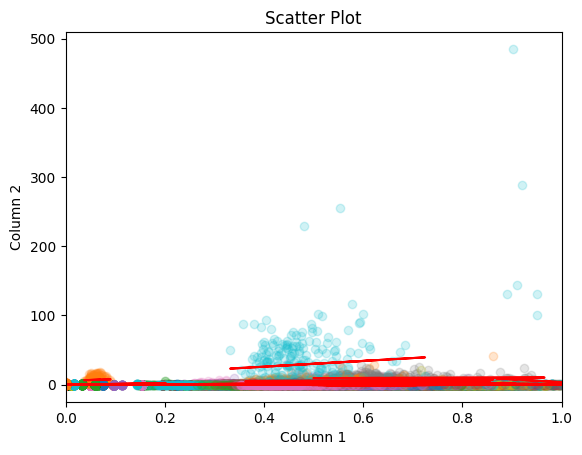

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = merged_df2.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
for label, group in tqdm(grouped):
    x = group['distance']
    y = group['sale_price']
    plt.scatter(x,y,alpha=0.2)
    plt.title('Scatter Plot')
    plt.xlabel('Column 1')
    plt.xlim(left=0,right=1)
    plt.ylabel('Column 2')
    try:
        coefficients = np.polyfit(x, y, 1)
        line_of_best_fit = np.polyval(coefficients, x)
        # Plot the line of best fit
        plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
    except:
        continue
    # plt.show()
    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x, y)
    if p_value<0.01:
        count+=1
        print(f"Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
print(count)

In [44]:
selected_columns = merged_df2[['Contract', 'NFT_num']].to_numpy().tolist()
rarities = alc.NFT_to_rarities(selected_columns)
# print(rarities)
# Column names for the DataFrame

columns = ['Contract', 'NFT_num', 'rarity']
# Create a DataFrame from the list of tuples
df_rare = pd.DataFrame(rarities, columns=columns)
merged_df_rare = pd.merge(df_rare, merged_df2, on=['Contract','NFT_num'])

100%|██████████████████████████████████████████████| 45641/45641 [49:22<00:00, 15.40it/s]


In [45]:
merged_df_rare

,Contract,NFT_num,rarity,Label,Features,Collection,sale_price,AverageFeatureVector,distance
0,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,100,1.163323e-03,0,"[0.003042250405997038, 0.03273392468690872, -0...",0-project,0.011944,"[-0.016509566906247688, 0.03234658735475285, -...",0.500848
1,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,107,9.196057e-04,0,"[0.005904476623982191, 0.043749768286943436, -...",0-project,0.028275,"[-0.016509566906247688, 0.03234658735475285, -...",0.569497
2,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,109,6.188351e-04,0,"[-0.05229974538087845, 0.030758129432797432, -...",0-project,0.051139,"[-0.016509566906247688, 0.03234658735475285, -...",0.373301
3,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,11,7.465128e-04,0,"[-0.0703972578048706, 0.03527277708053589, 0.0...",0-project,0.060450,"[-0.016509566906247688, 0.03234658735475285, -...",0.575614
4,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,110,5.816451e-04,0,"[-0.03696935251355171, 0.02721566893160343, -0...",0-project,0.021937,"[-0.016509566906247688, 0.03234658735475285, -...",0.526951
...,...,...,...,...,...,...,...,...,...
22045,0x760e2491182f960c40f5978fe6647935992150c1,898,3.956608e-07,606,"[-0.1365821361541748, 0.020808279514312744, -0...",chaoscityresidents,0.018514,"[-0.0707464454993769, 0.012973218782191683, -0...",0.465902
22046,0x760e2491182f960c40f5978fe6647935992150c1,912,3.822165e-07,606,"[-0.11039072275161743, 0.009459609165787697, -...",chaoscityresidents,0.017612,"[-0.0707464454993769, 0.012973218782191683, -0...",0.442554
22047,0x760e2491182f960c40f5978fe6647935992150c1,924,3.242238e-07,606,"[-0.08014600723981857, 0.023258356377482414, -...",chaoscityresidents,0.016390,"[-0.0707464454993769, 0.012973218782191683, -0...",0.411449
22048,0x760e2491182f960c40f5978fe6647935992150c1,959,5.504262e-07,606,"[-0.046986501663923264, 0.046262290328741074, ...",chaoscityresidents,0.016410,"[-0.0707464454993769, 0.012973218782191683, -0...",0.472663


In [19]:
merged_df_rare = df_filtered_rare.query('rarity<1')
df_filtered_rare = merged_df_rare.groupby('Collection').filter(lambda group: len(group) >= 100)
# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['Collection'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

Label counts:
Collection
bvgarden                       285
akumaorigins                   273
casual-sloths-official         244
catbloxgenesis                 240
azuki                          234
byopill                        233
bullsontheblock                216
big-town-chef-genesis-chefs    204
3600yako-nft                   204
8sian-main-collection          196
bammers                        192
chain-runners-nft              188
ape-mfers                      185
bfreeparty                     182
alphagirlclub                  170
a-common-place                 151
boredmilady                    151
arcadenft                      143
capsulehouse                   142
aikovirtual                    138
blazedcats                     137
bullsandapes-genesis           136
alinft-official                125
ape-harbour-yachts             124
broman-nft                     119
astarprince                    117
2545bygr4y                     117
cakedapesofficial             

  0%|                                                             | 0/95 [00:00<?, ?it/s]

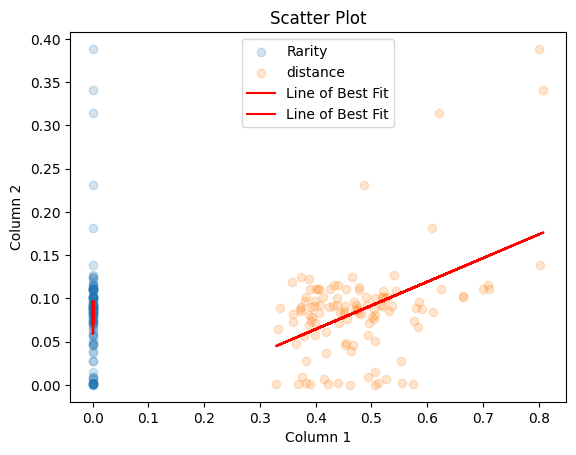

  3%|█▋                                                   | 3/95 [00:00<00:07, 11.52it/s]

(Rarity) Collection: 2545bygr4y, Correlation: 0.17785240018910056, P-Value:0.05505560743572183
(Distance) Collection: 2545bygr4y, Correlation: 0.4618897638096142, P-Value:1.5886744990675997e-07


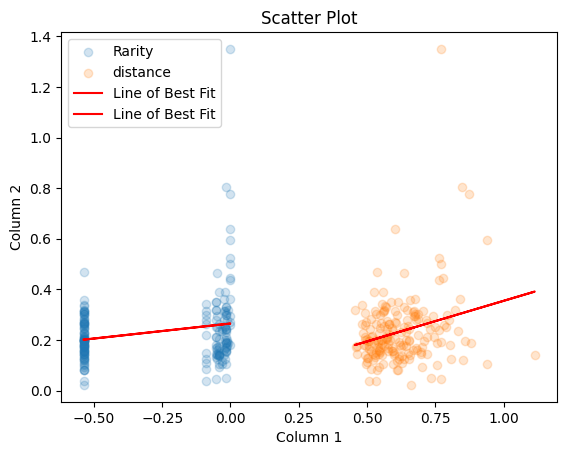

  8%|████▍                                                | 8/95 [00:00<00:05, 16.90it/s]

(Rarity) Collection: 8pes-dvnci, Correlation: 0.21771515616155243, P-Value:0.0028347275394353115
(Distance) Collection: 8pes-dvnci, Correlation: 0.25076930823363985, P-Value:0.0005558042078690095


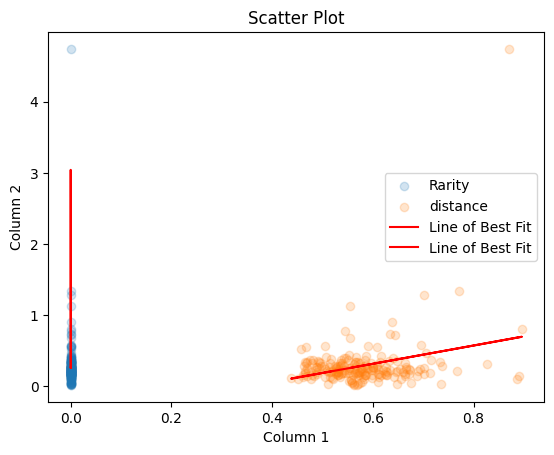

 11%|█████▍                                              | 10/95 [00:00<00:06, 13.98it/s]

(Rarity) Collection: 8sian-main-collection, Correlation: -0.7540790755935681, P-Value:8.07786823179551e-38
(Distance) Collection: 8sian-main-collection, Correlation: 0.291881758605335, P-Value:2.876715631620205e-05


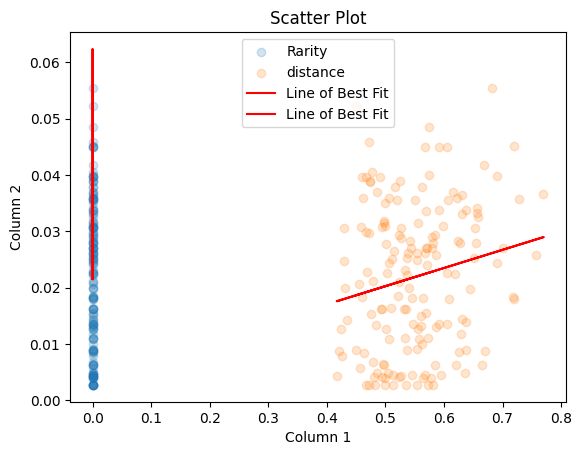

(Rarity) Collection: a-common-place, Correlation: -0.24859641830630289, P-Value:0.001283245900094605
(Distance) Collection: a-common-place, Correlation: 0.18570622323547845, P-Value:0.01693499401365774


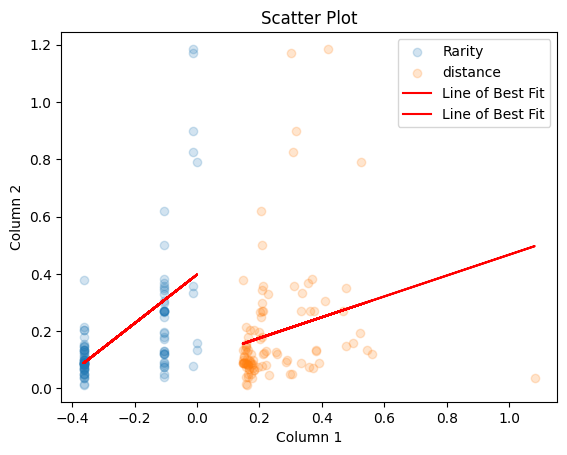

 13%|██████▌                                             | 12/95 [00:01<00:09,  9.17it/s]

(Rarity) Collection: a0k1verse-passport, Correlation: 0.5784440635714702, P-Value:1.926265559217656e-10
(Distance) Collection: a0k1verse-passport, Correlation: 0.23445898094211406, P-Value:0.017696954076654735


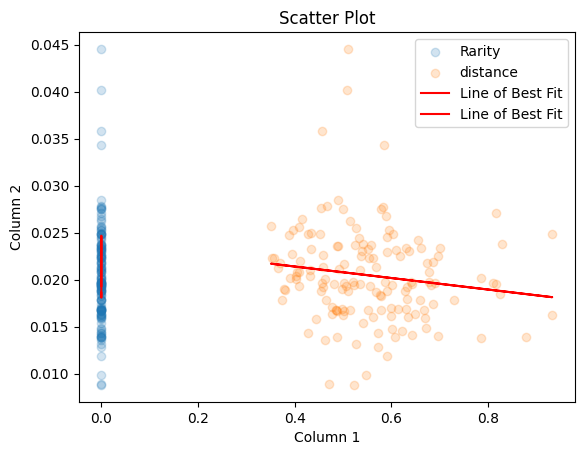

(Rarity) Collection: abstrascii, Correlation: 0.28072014939283185, P-Value:0.0005021994712544825
(Distance) Collection: abstrascii, Correlation: -0.14372026130740453, P-Value:0.07932733727960435


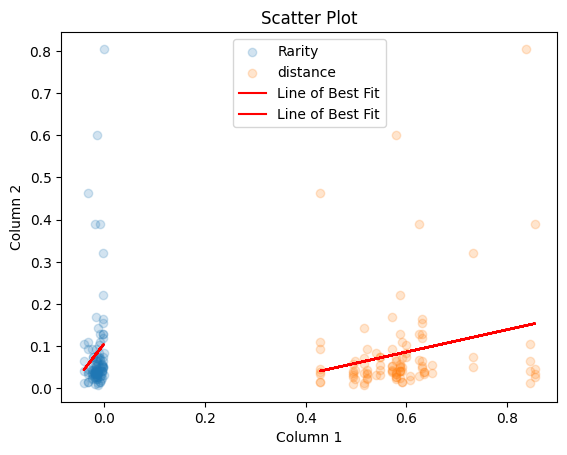

 15%|███████▋                                            | 14/95 [00:01<00:10,  7.45it/s]

(Rarity) Collection: acrocspacecraft, Correlation: 0.13442580311690985, P-Value:0.18239459479713926
(Distance) Collection: acrocspacecraft, Correlation: 0.23108544879107015, P-Value:0.02071139606981656


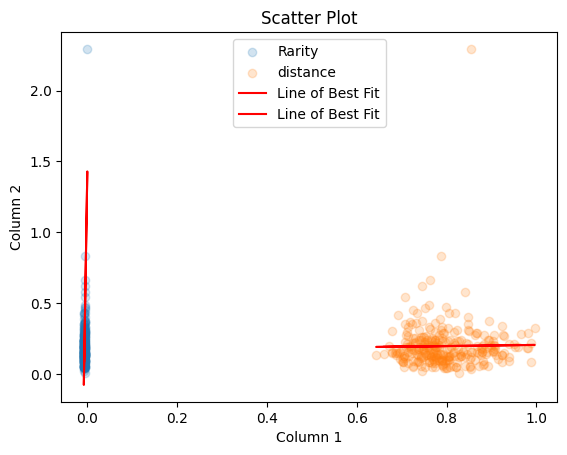

 19%|█████████▊                                          | 18/95 [00:01<00:07, 10.44it/s]

(Rarity) Collection: ainightbirds, Correlation: 0.642956936179795, P-Value:1.595882828240495e-34
(Distance) Collection: ainightbirds, Correlation: 0.017474137460863706, P-Value:0.769366966997775


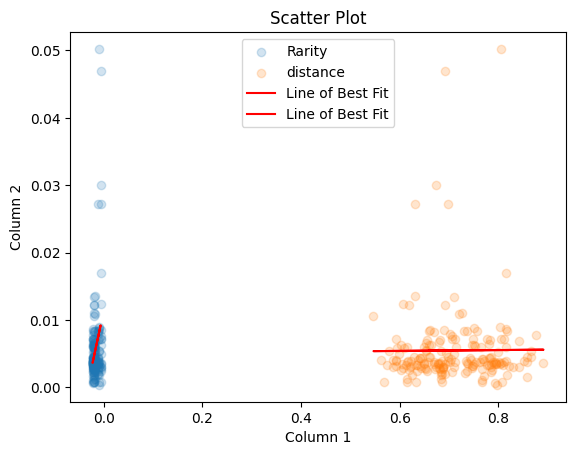

(Rarity) Collection: aipudgys, Correlation: 0.3027431901446415, P-Value:2.5373744734231284e-05
(Distance) Collection: aipudgys, Correlation: 0.008052999558229261, P-Value:0.912895945775957


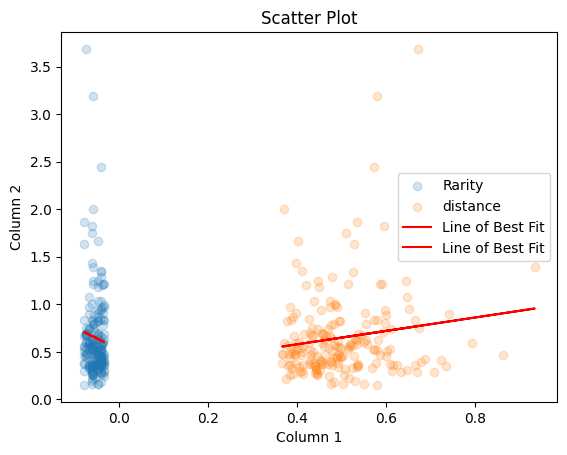

 21%|██████████▉                                         | 20/95 [00:02<00:08,  8.33it/s]

(Rarity) Collection: akidcalledbeast, Correlation: -0.06587656946386376, P-Value:0.35525012000653144
(Distance) Collection: akidcalledbeast, Correlation: 0.14695091642376606, P-Value:0.03834045650377279


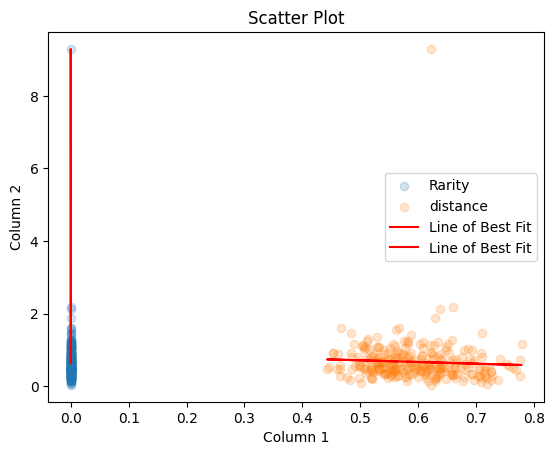

 23%|████████████                                        | 22/95 [00:02<00:10,  7.18it/s]

(Rarity) Collection: akumaorigins, Correlation: -0.8308185487528496, P-Value:3.465585788023952e-71
(Distance) Collection: akumaorigins, Correlation: -0.05467723161505613, P-Value:0.36726608564989494


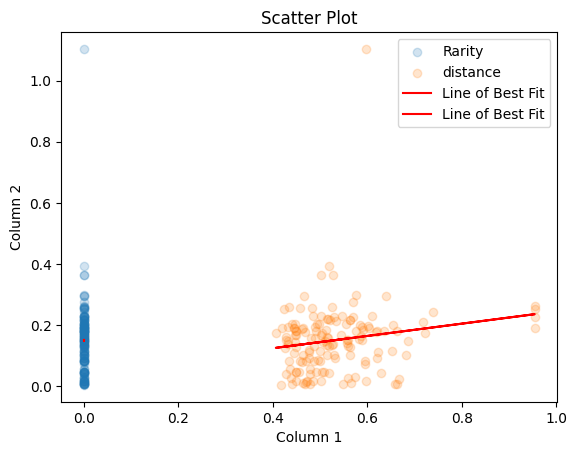

 24%|████████████▌                                       | 23/95 [00:02<00:10,  6.87it/s]

(Rarity) Collection: alinft-official, Correlation: 0.005776194374808556, P-Value:0.9446430892385383
(Distance) Collection: alinft-official, Correlation: 0.17796256722814657, P-Value:0.031044141850111756


/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


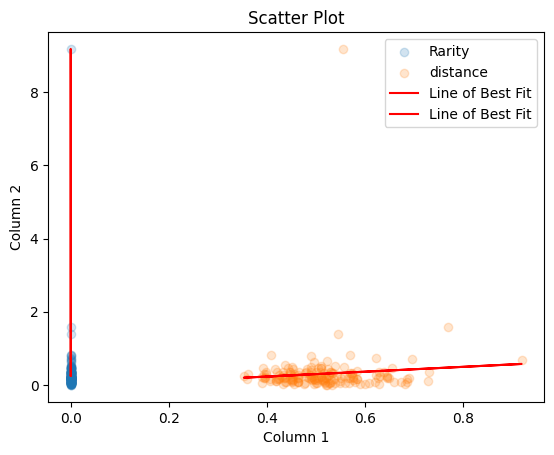

 27%|██████████████▏                                     | 26/95 [00:02<00:07,  9.08it/s]

(Rarity) Collection: alphagirlclub, Correlation: -0.9533126826457868, P-Value:8.421466399329136e-90
(Distance) Collection: alphagirlclub, Correlation: 0.08039494305771613, P-Value:0.2958924729883763


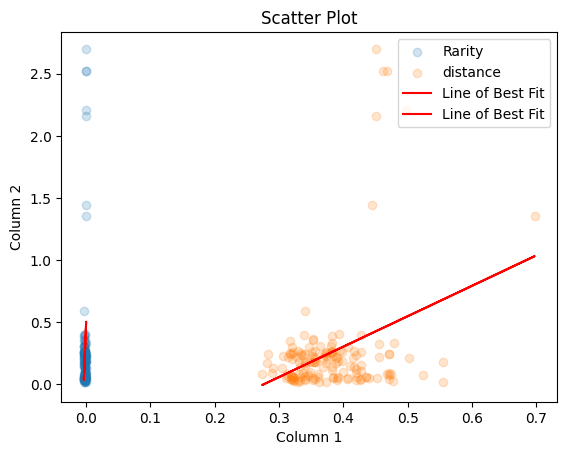

 29%|███████████████▎                                    | 28/95 [00:03<00:07,  9.31it/s]

(Rarity) Collection: ambushofficialpowreboot, Correlation: 0.32568189121316593, P-Value:4.491760581715842e-05
(Distance) Collection: ambushofficialpowreboot, Correlation: 0.34338011551013936, P-Value:1.58559337762138e-05


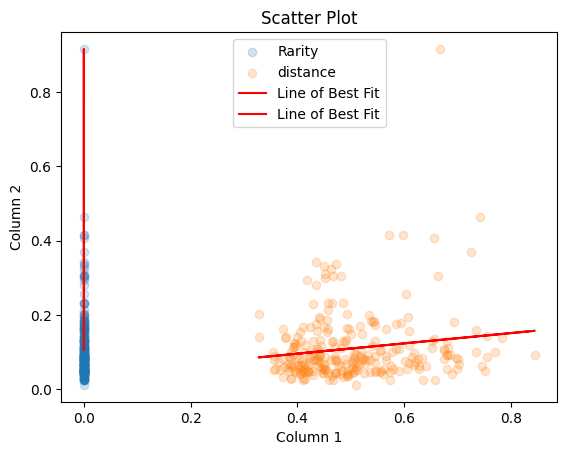

 32%|████████████████▍                                   | 30/95 [00:03<00:06,  9.62it/s]

(Rarity) Collection: ape-mfers, Correlation: -0.5409495302828301, P-Value:2.5781632045913544e-21
(Distance) Collection: ape-mfers, Correlation: 0.15474790464164054, P-Value:0.012142956770810325


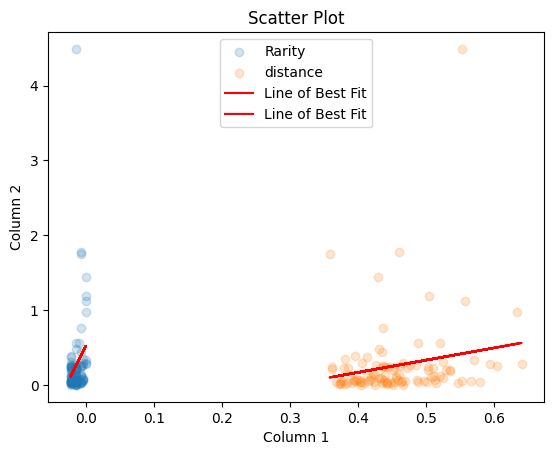

 34%|█████████████████▌                                  | 32/95 [00:03<00:06,  9.88it/s]

(Rarity) Collection: apymon, Correlation: 0.24793375310031784, P-Value:0.011160527031400658
(Distance) Collection: apymon, Correlation: 0.19412611604366325, P-Value:0.0483129176655948


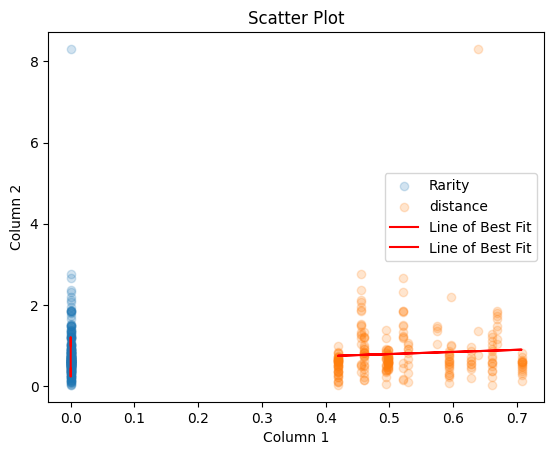

(Rarity) Collection: arcade-land, Correlation: 0.35055949799976077, P-Value:1.7101408166881978e-08
(Distance) Collection: arcade-land, Correlation: 0.0694526606747373, P-Value:0.2788729275666263


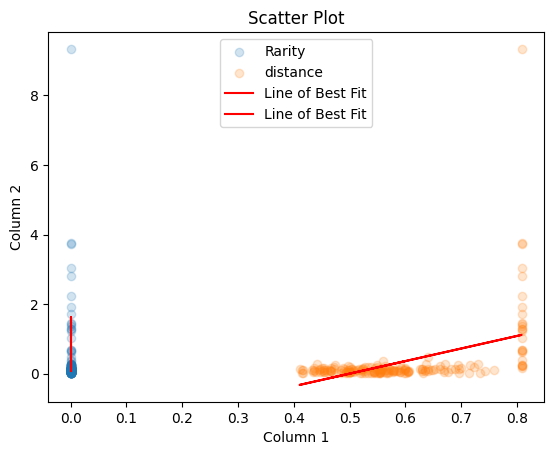

 36%|██████████████████▌                                 | 34/95 [00:03<00:07,  7.80it/s]

(Rarity) Collection: arcadenft, Correlation: -0.602769600739547, P-Value:4.438826442349236e-20
(Distance) Collection: arcadenft, Correlation: 0.4739057399490897, P-Value:5.6689659659929086e-12


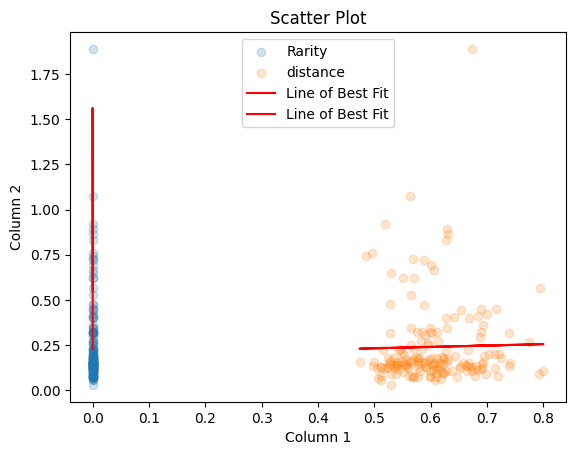

 38%|███████████████████▋                                | 36/95 [00:04<00:07,  8.20it/s]

(Rarity) Collection: atsnft, Correlation: -0.47778814094713434, P-Value:2.986735187449e-11
(Distance) Collection: atsnft, Correlation: 0.02229347046307109, P-Value:0.7709478747519827


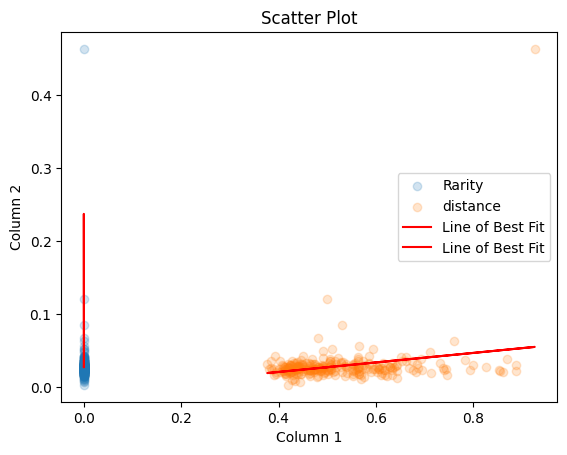

 39%|████████████████████▎                               | 37/95 [00:04<00:07,  7.55it/s]

(Rarity) Collection: atsui, Correlation: -0.6315147663237882, P-Value:6.740445849229613e-31
(Distance) Collection: atsui, Correlation: 0.24731466325407472, P-Value:4.693892684179953e-05


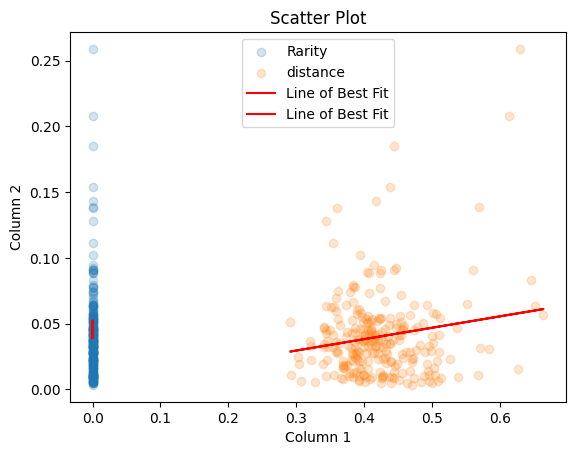

 41%|█████████████████████▎                              | 39/95 [00:04<00:06,  8.17it/s]

(Rarity) Collection: avius-animae, Correlation: -0.0743738061588765, P-Value:0.230235926176685
(Distance) Collection: avius-animae, Correlation: 0.16830678759587006, P-Value:0.006318762658901469


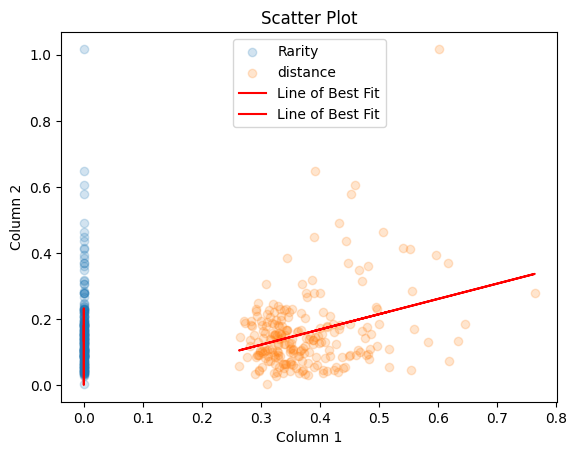

 42%|█████████████████████▉                              | 40/95 [00:04<00:07,  7.25it/s]

(Rarity) Collection: axolittles, Correlation: 0.39516949193529677, P-Value:6.099965280380199e-10
(Distance) Collection: axolittles, Correlation: 0.31731547071486926, P-Value:9.979641836945154e-07


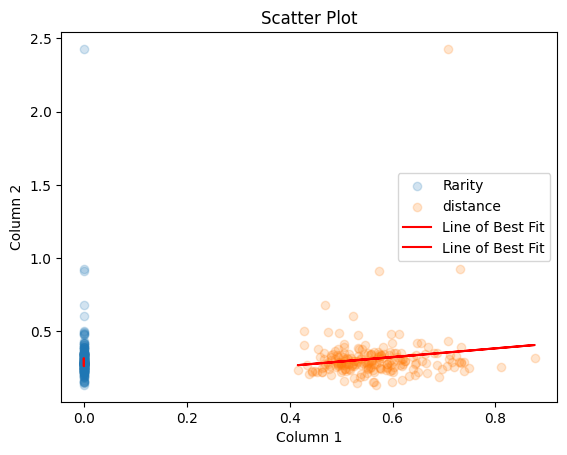

 43%|██████████████████████▍                             | 41/95 [00:04<00:07,  6.79it/s]

(Rarity) Collection: azragames-thehopeful, Correlation: 0.0294078710496007, P-Value:0.6725241192101625
(Distance) Collection: azragames-thehopeful, Correlation: 0.1361552574318628, P-Value:0.04932953440643835


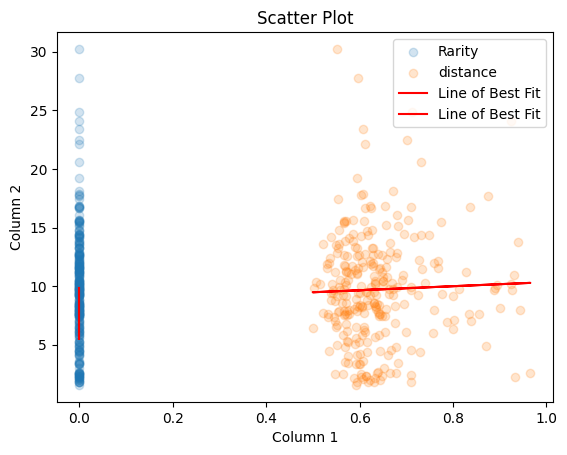

 44%|██████████████████████▉                             | 42/95 [00:04<00:08,  6.27it/s]

(Rarity) Collection: azuki, Correlation: 0.12665245505376788, P-Value:0.034469369027537805
(Distance) Collection: azuki, Correlation: 0.03378660455697971, P-Value:0.5741334821312273


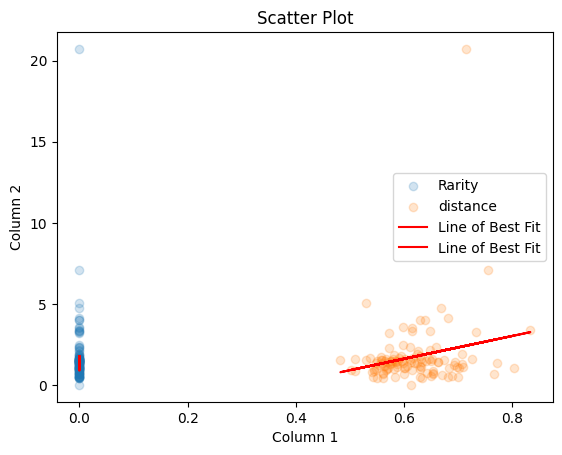

 45%|███████████████████████▌                            | 43/95 [00:05<00:08,  6.09it/s]

(Rarity) Collection: azukielementals, Correlation: 0.03877699970666245, P-Value:0.6794061297445999
(Distance) Collection: azukielementals, Correlation: 0.21846711879934372, P-Value:0.018472155598679676


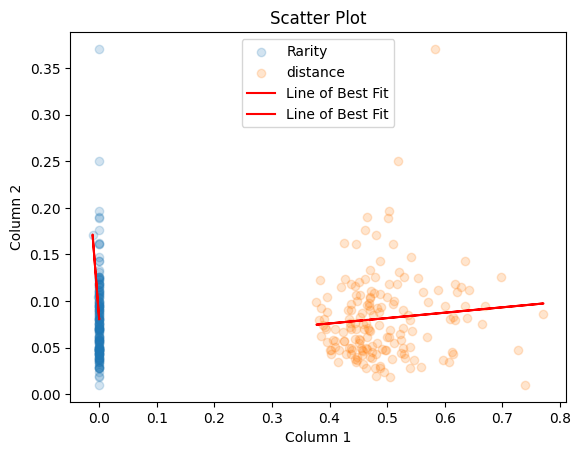

 46%|████████████████████████                            | 44/95 [00:05<00:09,  5.65it/s]

(Rarity) Collection: babbys, Correlation: -0.15546766740053938, P-Value:0.0441884459481248
(Distance) Collection: babbys, Correlation: 0.09550857240393752, P-Value:0.21813315058288094


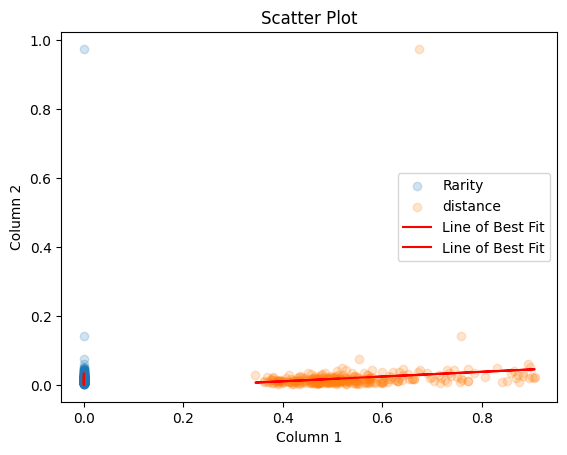

 51%|██████████████████████████▎                         | 48/95 [00:05<00:04, 10.14it/s]

(Rarity) Collection: bankrupt-ftx-yacht-club, Correlation: 0.1573734791812705, P-Value:0.007149123693082342
(Distance) Collection: bankrupt-ftx-yacht-club, Correlation: 0.14887205665668848, P-Value:0.010996124528605678


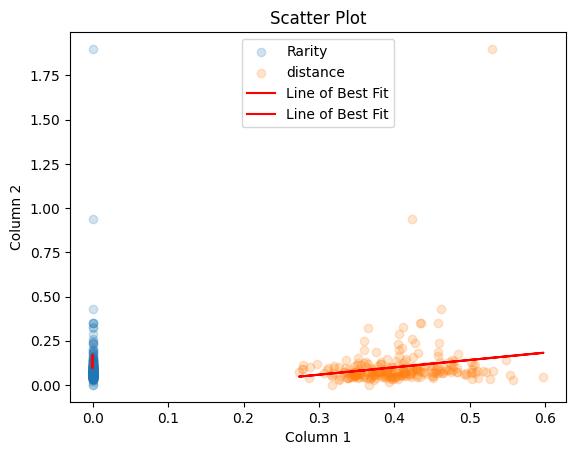

(Rarity) Collection: barn-owlz, Correlation: -0.07703814094310509, P-Value:0.22861589676167152
(Distance) Collection: barn-owlz, Correlation: 0.1727331484701777, P-Value:0.0066104028389223895


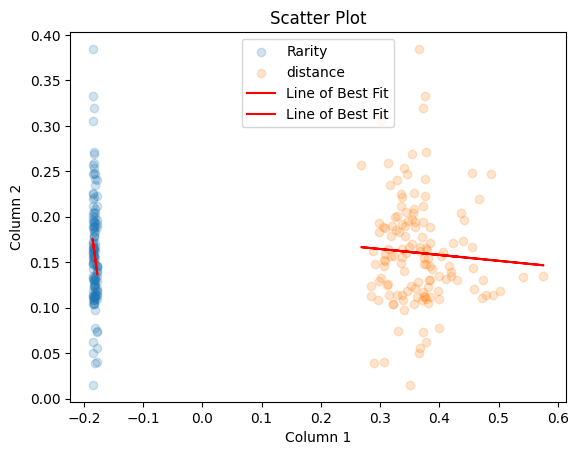

 53%|███████████████████████████▎                        | 50/95 [00:05<00:05,  7.52it/s]

(Rarity) Collection: basedheads, Correlation: -0.2224697103672069, P-Value:0.009502859580820656
(Distance) Collection: basedheads, Correlation: -0.05983265474235154, P-Value:0.490605545123935


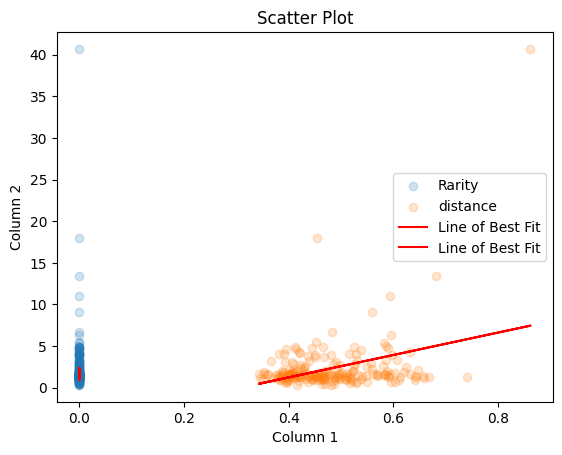

 54%|███████████████████████████▉                        | 51/95 [00:06<00:06,  6.96it/s]

(Rarity) Collection: beanzofficial, Correlation: 0.05568392183686301, P-Value:0.42436847847256265
(Distance) Collection: beanzofficial, Correlation: 0.3420564691172068, P-Value:4.262423097451052e-07


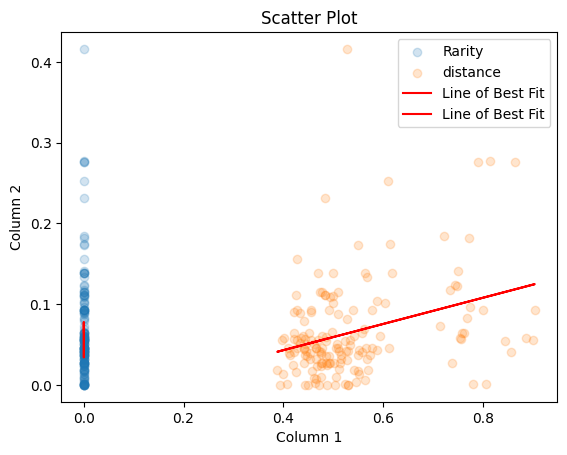

 55%|████████████████████████████▍                       | 52/95 [00:06<00:06,  6.67it/s]

(Rarity) Collection: bearmarketbears, Correlation: 0.16491858182352964, P-Value:0.03715935702753643
(Distance) Collection: bearmarketbears, Correlation: 0.3229315957715851, P-Value:3.114701681897238e-05


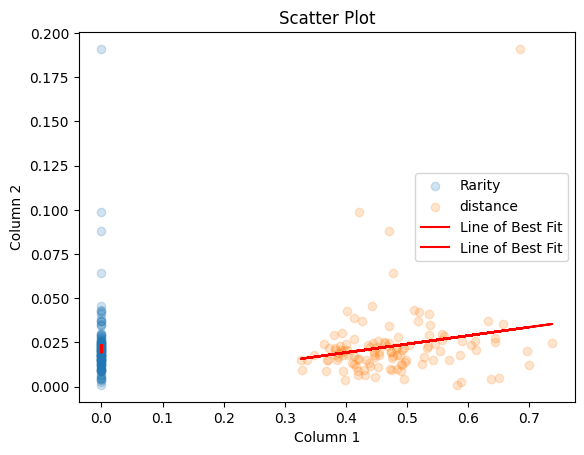

 56%|█████████████████████████████                       | 53/95 [00:06<00:06,  6.13it/s]

(Rarity) Collection: beartings, Correlation: 0.04010142618167188, P-Value:0.6636596187975268
(Distance) Collection: beartings, Correlation: 0.20086149370962014, P-Value:0.02782343511700805


/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


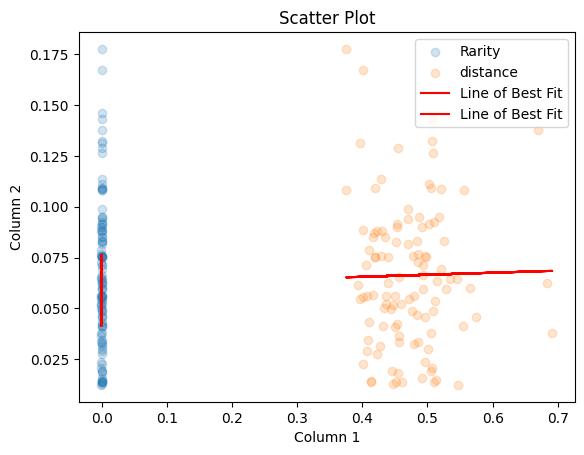

 61%|███████████████████████████████▋                    | 58/95 [00:06<00:03, 11.27it/s]

(Rarity) Collection: binary1010-brx, Correlation: 0.3023890492732543, P-Value:0.001394433437080317
(Distance) Collection: binary1010-brx, Correlation: 0.016289223622358105, P-Value:0.8664928236509882


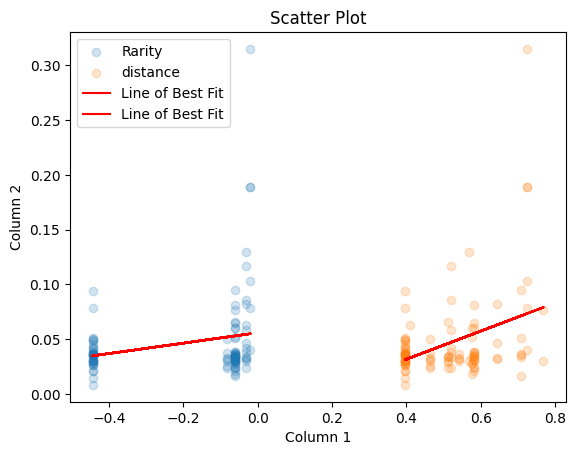

(Rarity) Collection: biplane-bobo, Correlation: 0.2336082216274957, P-Value:0.017001518554987306
(Distance) Collection: biplane-bobo, Correlation: 0.36793775761760117, P-Value:0.00012173850128663113


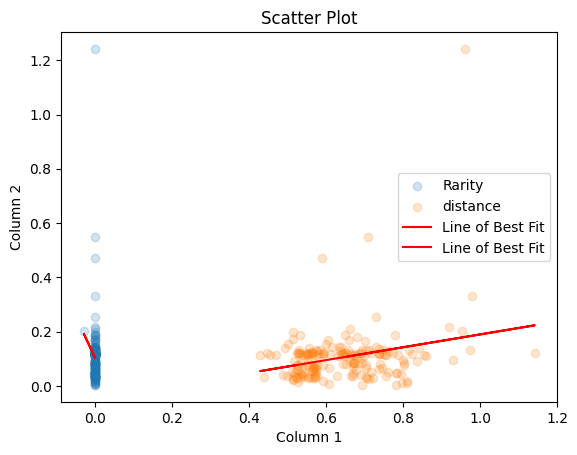

 63%|████████████████████████████████▊                   | 60/95 [00:07<00:04,  8.68it/s]

(Rarity) Collection: blankfaceofficial, Correlation: -0.059939381574898885, P-Value:0.41767181307539936
(Distance) Collection: blankfaceofficial, Correlation: 0.2604123638055383, P-Value:0.0003436580189319307


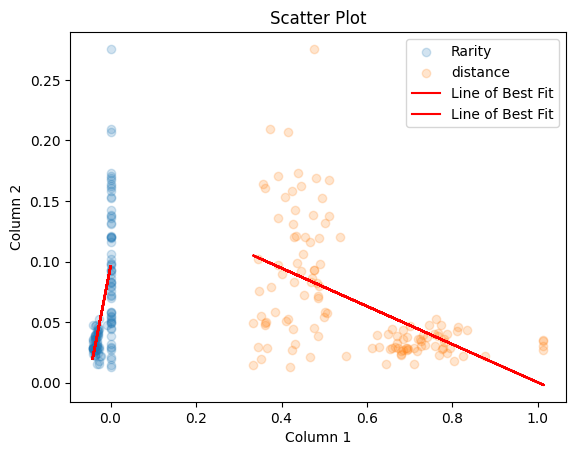

 65%|█████████████████████████████████▉                  | 62/95 [00:07<00:03,  9.16it/s]

(Rarity) Collection: blockalizer-chroma, Correlation: 0.6226029863941781, P-Value:7.0716521389120504e-15
(Distance) Collection: blockalizer-chroma, Correlation: -0.5305932008186339, P-Value:1.654105299149607e-10


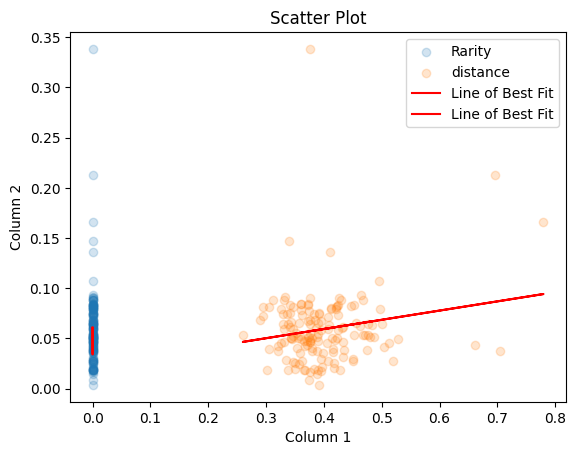

 67%|███████████████████████████████████                 | 64/95 [00:07<00:03,  9.33it/s]

(Rarity) Collection: blockydoge3, Correlation: 0.10278393683460826, P-Value:0.20916543702074006
(Distance) Collection: blockydoge3, Correlation: 0.18530144082751437, P-Value:0.022734648599866937


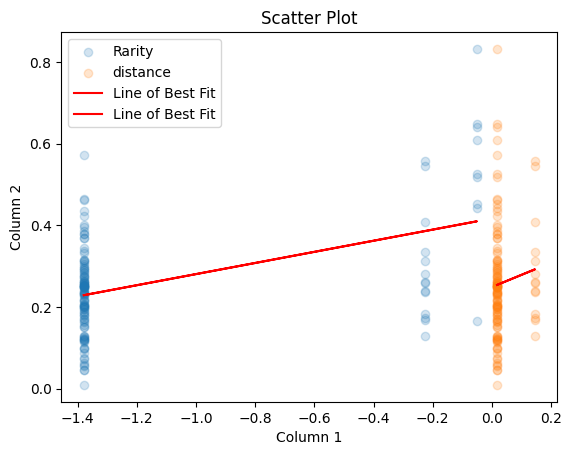

 73%|█████████████████████████████████████▊              | 69/95 [00:07<00:01, 13.68it/s]

(Rarity) Collection: bored-and-dangerous, Correlation: 0.4897955880488034, P-Value:2.897469696940523e-09
(Distance) Collection: bored-and-dangerous, Correlation: 0.0870111299814377, P-Value:0.32304544865429086


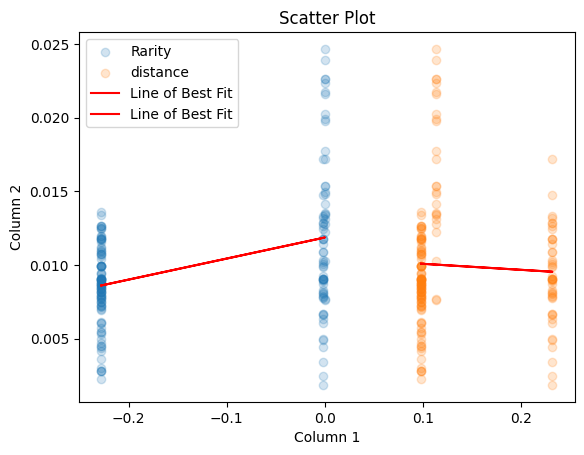

 76%|███████████████████████████████████████▍            | 72/95 [00:07<00:01, 14.38it/s]

(Rarity) Collection: bored-grapes-bottles, Correlation: 0.3789292916128625, P-Value:2.1490992122637394e-07
(Distance) Collection: bored-grapes-bottles, Correlation: -0.055992061614347666, P-Value:0.4604506952388955


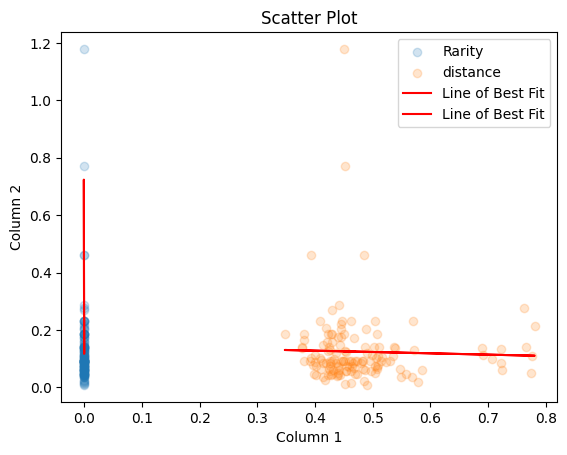

 78%|████████████████████████████████████████▌           | 74/95 [00:08<00:01, 12.58it/s]

(Rarity) Collection: bored-mummy-baby-waking-up, Correlation: -0.40850459624960217, P-Value:5.96743049667519e-07
(Distance) Collection: bored-mummy-baby-waking-up, Correlation: -0.03206258836478071, P-Value:0.7078871862739997


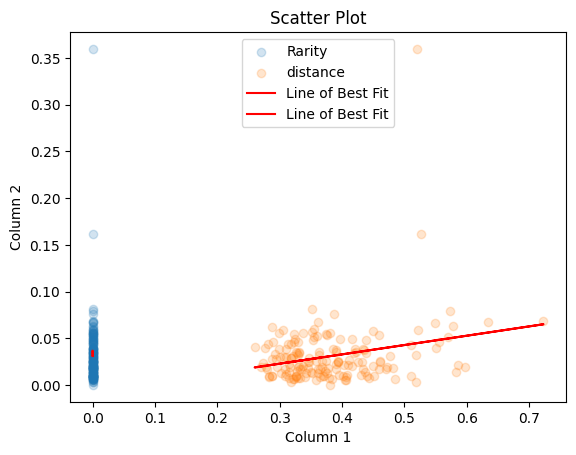

 80%|█████████████████████████████████████████▌          | 76/95 [00:08<00:01, 11.12it/s]

(Rarity) Collection: boredapeyogaclub, Correlation: -0.019060786027261516, P-Value:0.8091668771099025
(Distance) Collection: boredapeyogaclub, Correlation: 0.24985644744552613, P-Value:0.001297294155549561


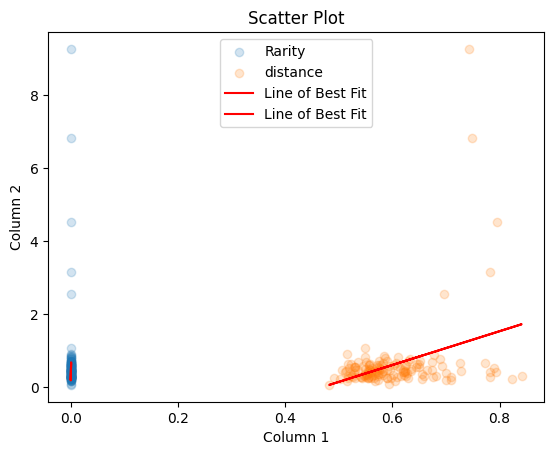

 83%|███████████████████████████████████████████▏        | 79/95 [00:08<00:01, 11.84it/s]

(Rarity) Collection: budverse-cans-heritage-edition, Correlation: 0.09965603635550527, P-Value:0.2346716009290098
(Distance) Collection: budverse-cans-heritage-edition, Correlation: 0.34200135368256823, P-Value:2.72303243649486e-05


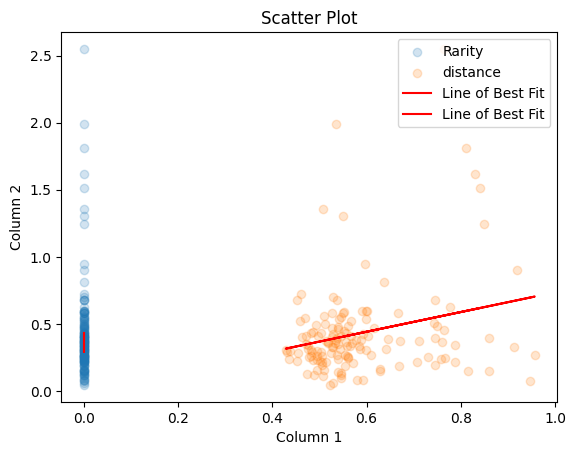

 85%|████████████████████████████████████████████▎       | 81/95 [00:08<00:01, 11.38it/s]

(Rarity) Collection: bullsandapes-genesis, Correlation: 0.03340645782776979, P-Value:0.6930823489139885
(Distance) Collection: bullsandapes-genesis, Correlation: 0.24299326490463521, P-Value:0.0035704859651626564


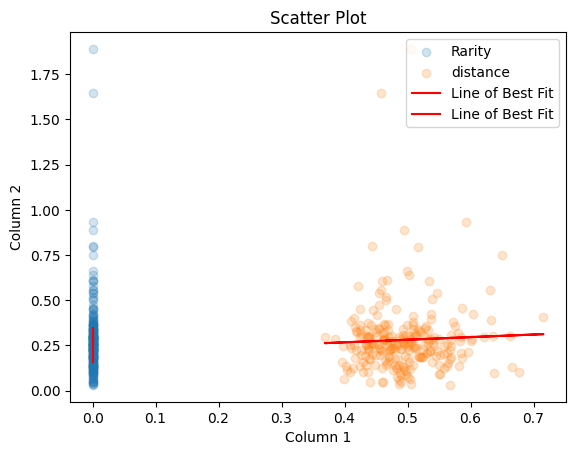

 89%|██████████████████████████████████████████████▌     | 85/95 [00:09<00:00, 13.43it/s]

(Rarity) Collection: cakedapesofficial, Correlation: 0.19989276420575905, P-Value:0.0013329257092294243
(Distance) Collection: cakedapesofficial, Correlation: 0.043130767651566954, P-Value:0.49291589558741533


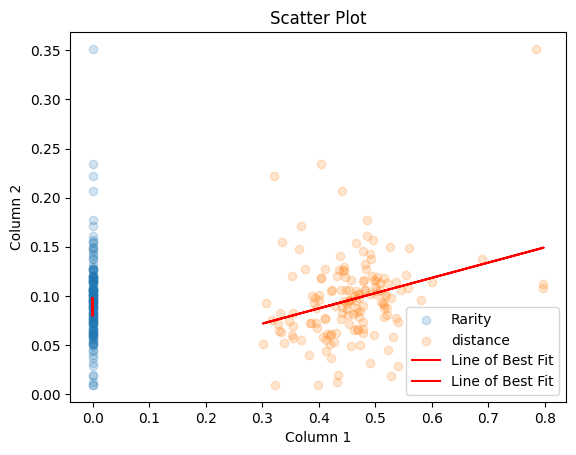

 93%|████████████████████████████████████████████████▏   | 88/95 [00:09<00:00, 10.41it/s]

(Rarity) Collection: cartoonsnft, Correlation: 0.06619643495404541, P-Value:0.4177812023998785
(Distance) Collection: cartoonsnft, Correlation: 0.2919421104873465, P-Value:0.0002628301063078146


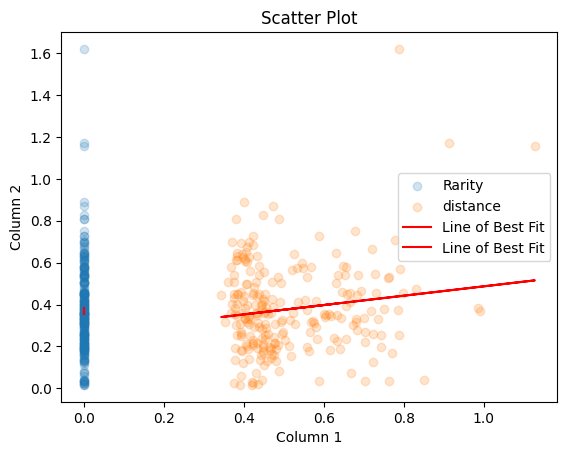

 96%|█████████████████████████████████████████████████▊  | 91/95 [00:09<00:00, 11.42it/s]

(Rarity) Collection: catbloxgenesis, Correlation: 0.04082755278952048, P-Value:0.5290492101930551
(Distance) Collection: catbloxgenesis, Correlation: 0.145451036755167, P-Value:0.024224420487796553


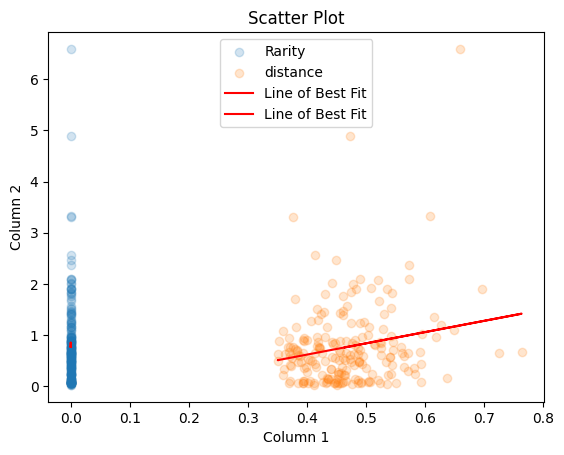

 98%|██████████████████████████████████████████████████▉ | 93/95 [00:09<00:00, 10.96it/s]

(Rarity) Collection: chain-runners-nft, Correlation: -0.009146020439298318, P-Value:0.8964453203019463
(Distance) Collection: chain-runners-nft, Correlation: 0.2053184426218465, P-Value:0.0031443104362638744


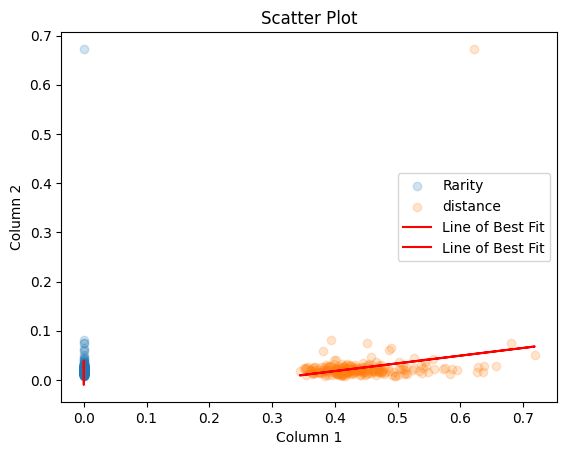

100%|████████████████████████████████████████████████████| 95/95 [00:10<00:00,  9.42it/s]

(Rarity) Collection: chaoscityresidents, Correlation: 0.187177445559883, P-Value:0.004569816472018739
(Distance) Collection: chaoscityresidents, Correlation: 0.2278533541982919, P-Value:0.0005256732017147031
Rare: 26, Rare Neg: 15, Dist: 39, Dist Neg:13


In [15]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    x_1 = 1-group['rarity']
    x_2 = group['distance']
    y = group['sale_price']

    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x_1, y)
    correlation_2, p_value_2 = pearsonr(x_2, y)
    if p_value<p_value_2:
        if correlation<0:
            count_rare_neg+=1
        else:
            count_rare+=1
    if p_value>p_value_2:
        if correlation<0:
            count_dist_neg+=1
        else:
            count_dist+=1
    if p_value<0.05 or p_value_2<0.05:
        x_1 = np.log(x_1)
        plt.scatter(x_1,y,alpha=0.2,label='Rarity')
        plt.scatter(x_2,y,alpha=0.2,label='distance')
        plt.title('Scatter Plot')
        plt.xlabel('Column 1')
        # plt.xlim(left=0,right=1)
        plt.ylabel('Column 2')
        try:
            coefficients = np.polyfit(x_1, y, 1)
            line_of_best_fit = np.polyval(coefficients, x_1)
            # Plot the line of best fit
            plt.plot(x_1, line_of_best_fit, color='red', label='Line of Best Fit')
            coefficients = np.polyfit(x_2, y, 1)
            line_of_best_fit = np.polyval(coefficients, x_2)
            # Plot the line of best fit
            plt.plot(x_2, line_of_best_fit, color='red', label='Line of Best Fit')
        except:
            continue
        plt.legend()
        plt.show()
        
        count+=1
        print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
        print(f"(Distance) Collection: {label}, Correlation: {correlation_2}, P-Value:{p_value_2}")
print(f"Rare: {count_rare}, Rare Neg: {count_rare_neg}, Dist: {count_dist}, Dist Neg:{count_dist_neg}")

In [14]:
from sklearn.metrics import r2_score
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    x_1 = 1-group['rarity']
    x_2 = group['distance']
    y = group['sale_price']

    # Compute correlation coefficient and p-value
    rare_r2 = r2_score( y,x_1)
    dist_r2= r2_score(y,x_2)
    if rare_r2>dist_r2:
        count_rare+=1
    else:
        count_dist+=1
print(count_rare,count_dist)

100%|███████████████████████████████████████████████████| 95/95 [00:00<00:00, 940.83it/s]

9 86


In [59]:
with open('rarity_distance.pkl','wb') as f:
    pickle.dump(df_filtered_rare,f)

In [3]:
with open('rarity_distance.pkl','rb') as f:
    df_filtered_rare = pickle.load(f)

In [5]:

# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['rarity'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

Label counts:
rarity
1.000000e+00    1644
9.259259e-03     191
5.000000e-01     133
7.480865e-01     108
2.037184e-01     104
                ... 
1.890344e-06       1
1.764772e-06       1
3.198771e-06       1
4.214858e-07       1
3.097689e-07       1
Name: count, Length: 14234, dtype: int64


  0%|                                                            | 0/105 [00:00<?, ?it/s]/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


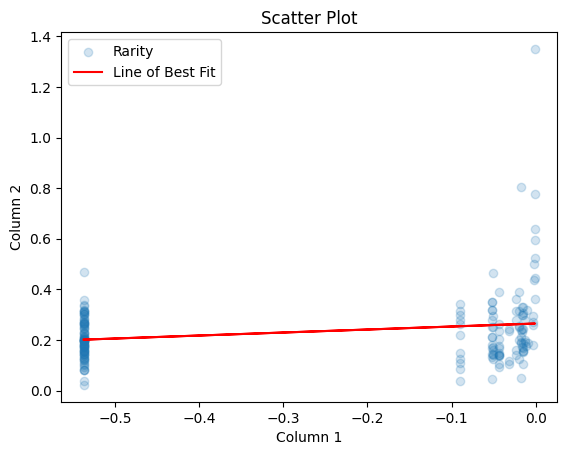

  9%|████▍                                               | 9/105 [00:00<00:04, 21.48it/s]

(Rarity) Collection: 8pes-dvnci, Correlation: 0.21771515616155243, P-Value:0.0028347275394353115


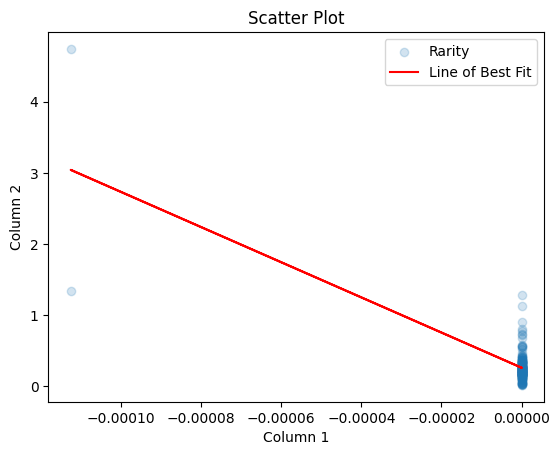

(Rarity) Collection: 8sian-main-collection, Correlation: -0.7540790755935681, P-Value:8.07786823179551e-38


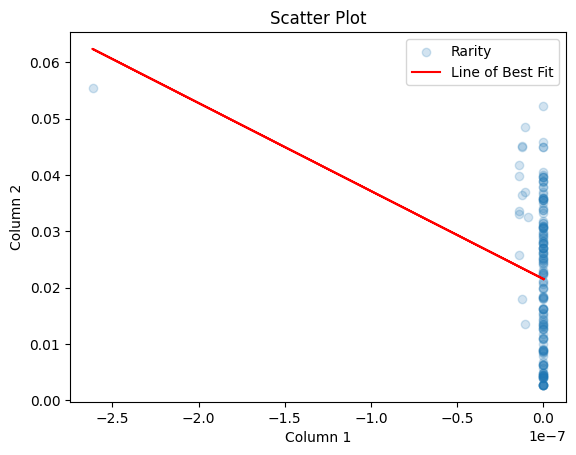

 11%|█████▊                                             | 12/105 [00:00<00:06, 13.66it/s]

(Rarity) Collection: a-common-place, Correlation: -0.24859641830630289, P-Value:0.001283245900094605


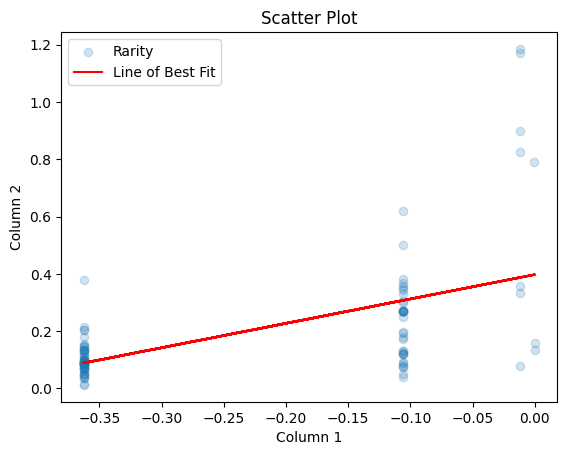

 13%|██████▊                                            | 14/105 [00:01<00:07, 12.49it/s]

(Rarity) Collection: a0k1verse-passport, Correlation: 0.5784440635714702, P-Value:1.926265559217656e-10


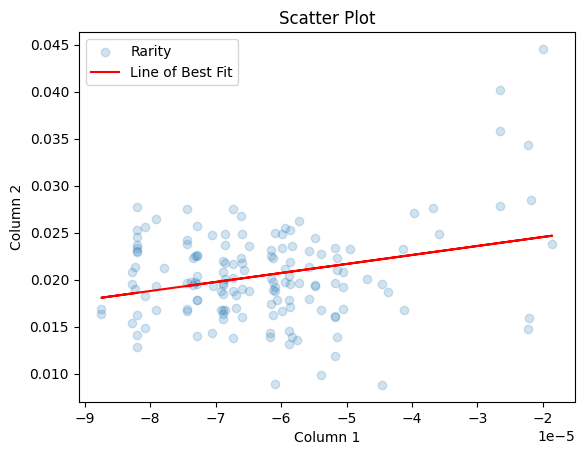

 15%|███████▊                                           | 16/105 [00:01<00:07, 12.13it/s]

(Rarity) Collection: abstrascii, Correlation: 0.28072014939283185, P-Value:0.0005021994712544825


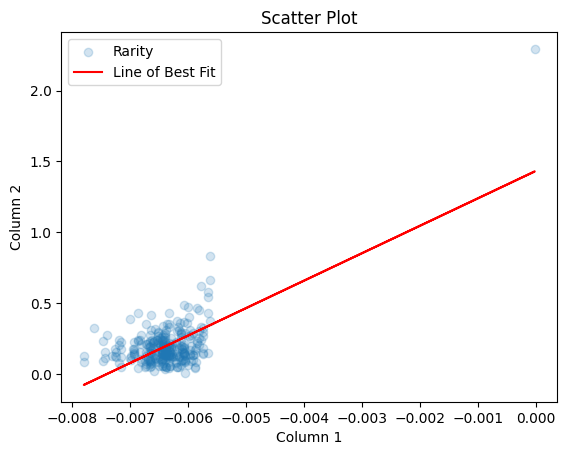

 20%|██████████▏                                        | 21/105 [00:01<00:04, 16.82it/s]

(Rarity) Collection: ainightbirds, Correlation: 0.642956936179795, P-Value:1.595882828240495e-34


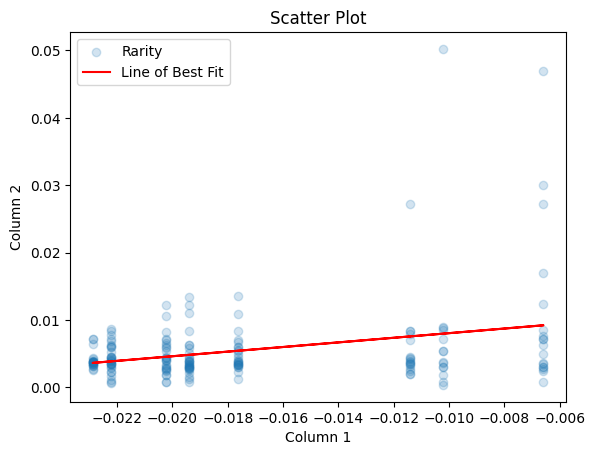

/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
 22%|███████████▏                                       | 23/105 [00:01<00:07, 11.31it/s]

(Rarity) Collection: aipudgys, Correlation: 0.3027431901446415, P-Value:2.5373744734231284e-05


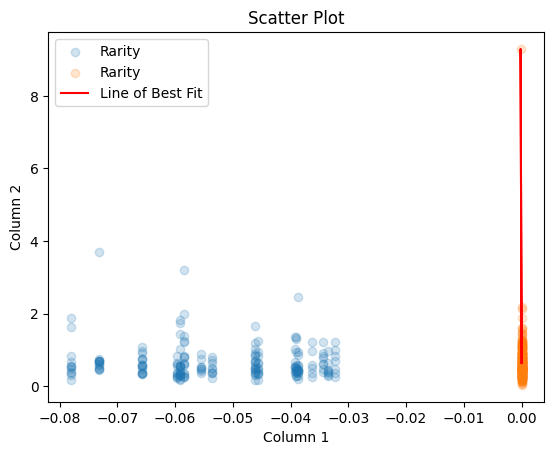

 24%|████████████▏                                      | 25/105 [00:01<00:07, 11.38it/s]

(Rarity) Collection: akumaorigins, Correlation: -0.8308185487528496, P-Value:3.465585788023952e-71


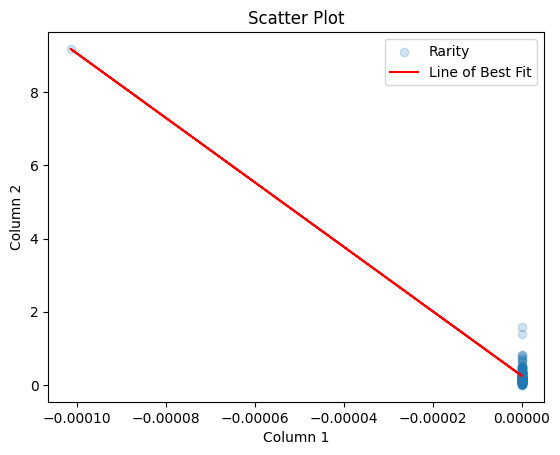

 29%|██████████████▌                                    | 30/105 [00:02<00:04, 16.10it/s]

(Rarity) Collection: alphagirlclub, Correlation: -0.9533126826457868, P-Value:8.421466399329136e-90


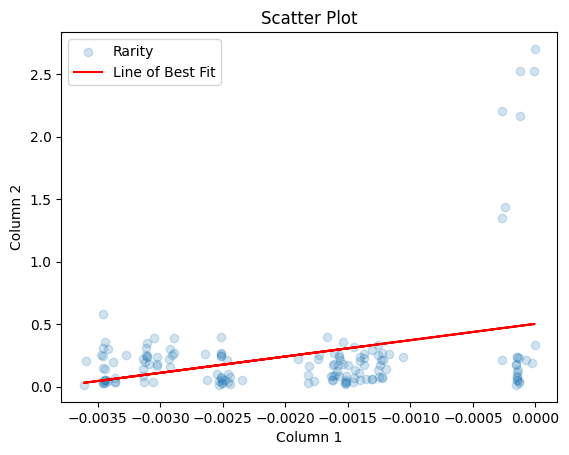

 30%|███████████████▌                                   | 32/105 [00:02<00:04, 14.98it/s]

(Rarity) Collection: ambushofficialpowreboot, Correlation: 0.32568189121316593, P-Value:4.491760581715842e-05


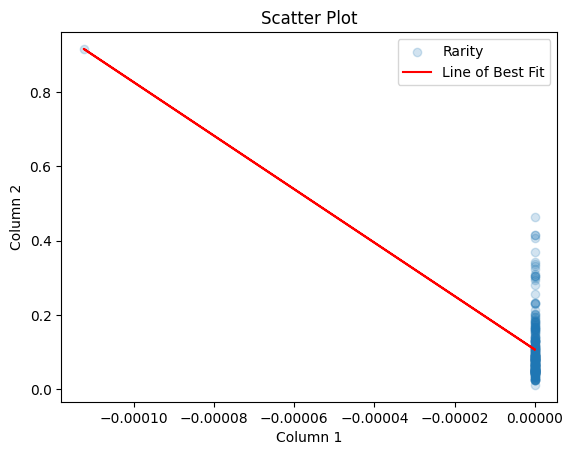

 32%|████████████████▌                                  | 34/105 [00:02<00:04, 14.40it/s]

(Rarity) Collection: ape-mfers, Correlation: -0.5409495302828301, P-Value:2.5781632045913544e-21


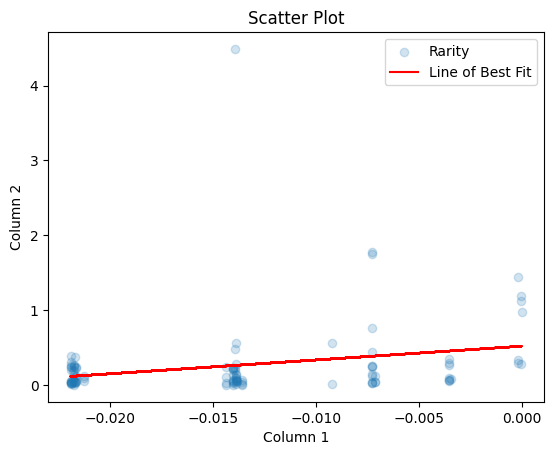

 35%|█████████████████▉                                 | 37/105 [00:02<00:04, 15.83it/s]

(Rarity) Collection: apymon, Correlation: 0.24793375310031784, P-Value:0.011160527031400658


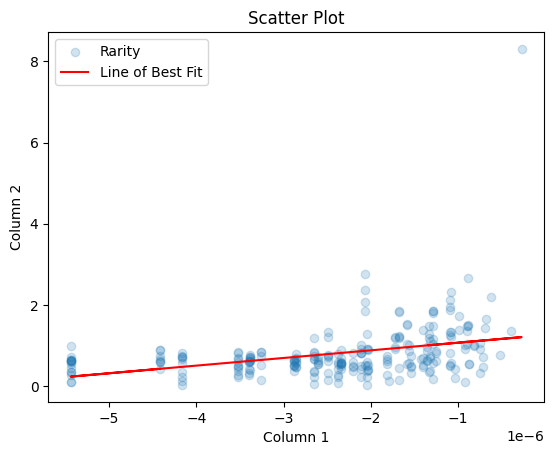

(Rarity) Collection: arcade-land, Correlation: 0.35055949799976077, P-Value:1.7101408166881978e-08


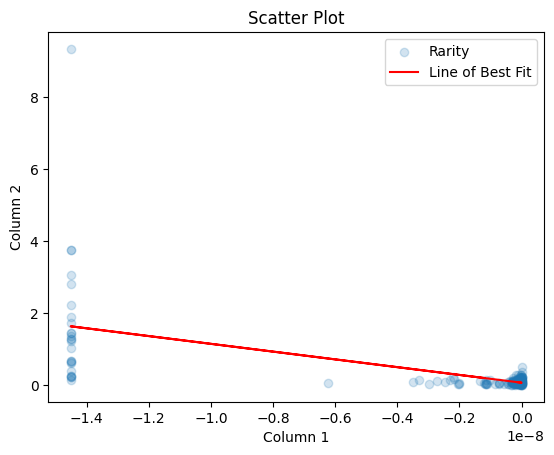

 37%|██████████████████▉                                | 39/105 [00:02<00:05, 11.83it/s]

(Rarity) Collection: arcadenft, Correlation: -0.602769600739547, P-Value:4.438826442349236e-20


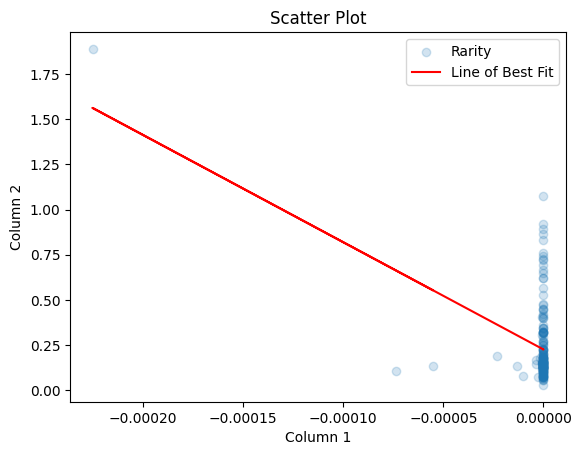

 41%|████████████████████▉                              | 43/105 [00:03<00:04, 14.82it/s]

(Rarity) Collection: atsnft, Correlation: -0.47778814094713434, P-Value:2.986735187449e-11


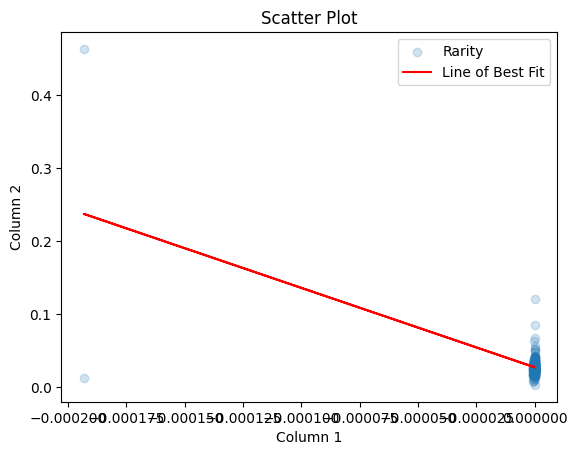

 43%|█████████████████████▊                             | 45/105 [00:03<00:04, 14.00it/s]

(Rarity) Collection: atsui, Correlation: -0.6315147663237882, P-Value:6.740445849229613e-31


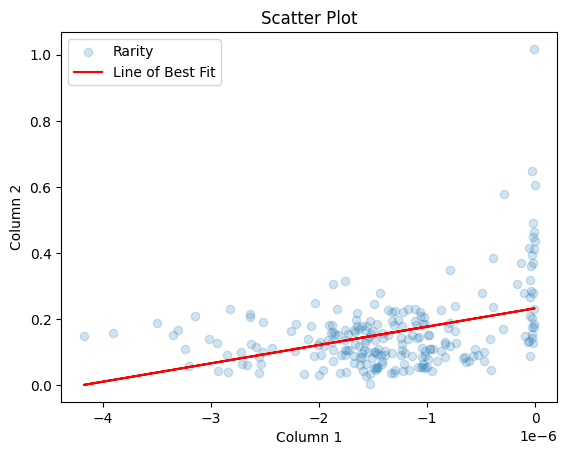

 46%|███████████████████████▎                           | 48/105 [00:03<00:03, 15.25it/s]

(Rarity) Collection: axolittles, Correlation: 0.39516949193529677, P-Value:6.099965280380199e-10


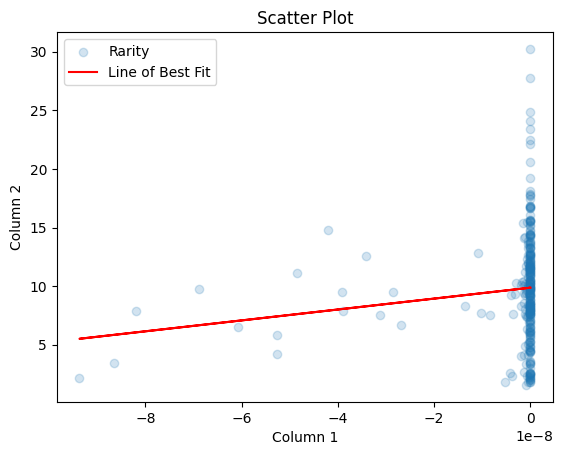

 48%|████████████████████████▎                          | 50/105 [00:03<00:03, 14.60it/s]

(Rarity) Collection: azuki, Correlation: 0.12665245505376788, P-Value:0.034469369027537805


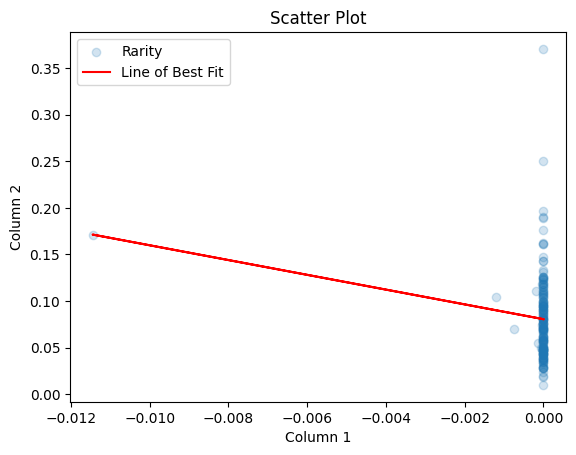

 50%|█████████████████████████▎                         | 52/105 [00:03<00:03, 13.63it/s]

(Rarity) Collection: babbys, Correlation: -0.15546766740053938, P-Value:0.0441884459481248


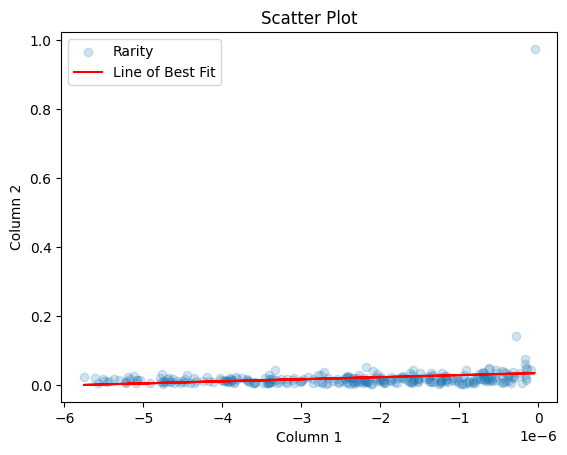

 53%|███████████████████████████▏                       | 56/105 [00:03<00:03, 15.80it/s]

(Rarity) Collection: bankrupt-ftx-yacht-club, Correlation: 0.1573734791812705, P-Value:0.007149123693082342


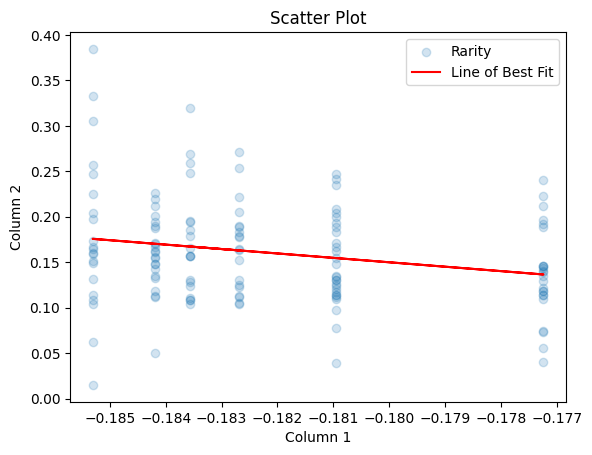

 55%|████████████████████████████▏                      | 58/105 [00:04<00:03, 14.19it/s]

(Rarity) Collection: basedheads, Correlation: -0.2224697103672069, P-Value:0.009502859580820656


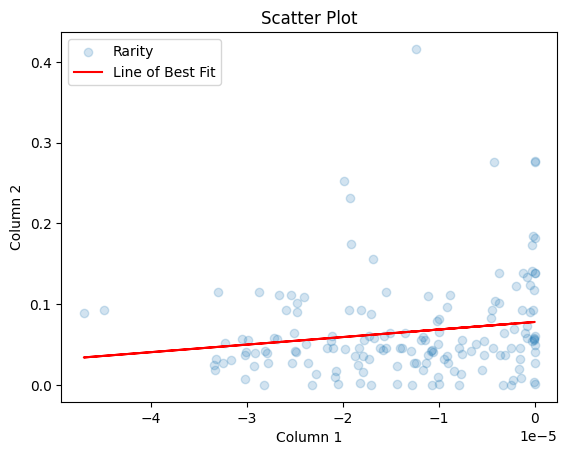

 57%|█████████████████████████████▏                     | 60/105 [00:04<00:03, 13.90it/s]

(Rarity) Collection: bearmarketbears, Correlation: 0.16491858182352964, P-Value:0.03715935702753643


/global/scratch/tlundy/NFT_Research/nft_venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


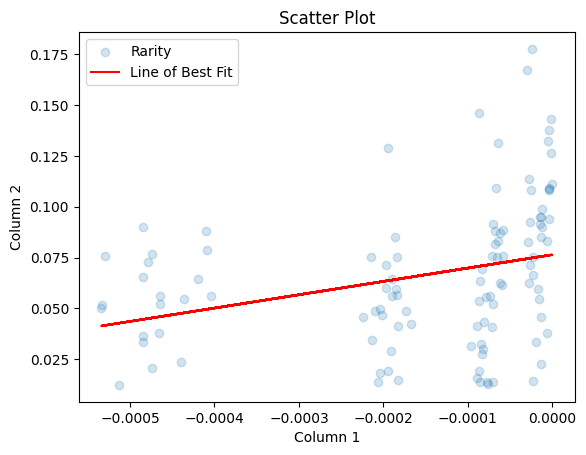

 63%|████████████████████████████████                   | 66/105 [00:04<00:02, 19.44it/s]

(Rarity) Collection: binary1010-brx, Correlation: 0.3023890492732543, P-Value:0.001394433437080317


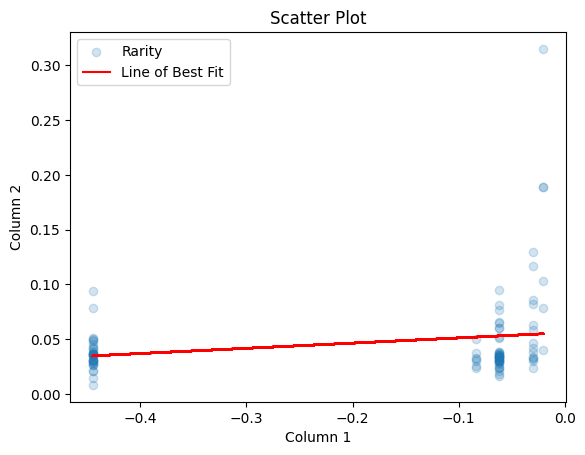

 65%|█████████████████████████████████                  | 68/105 [00:04<00:02, 16.51it/s]

(Rarity) Collection: biplane-bobo, Correlation: 0.2336082216274957, P-Value:0.017001518554987306


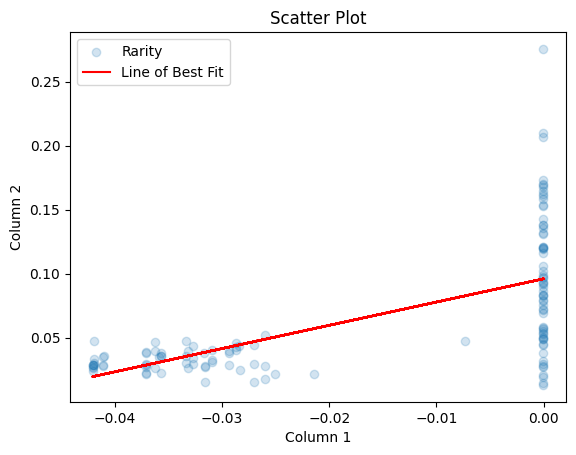

 68%|██████████████████████████████████▍                | 71/105 [00:04<00:02, 16.36it/s]

(Rarity) Collection: blockalizer-chroma, Correlation: 0.6226029863941781, P-Value:7.0716521389120504e-15


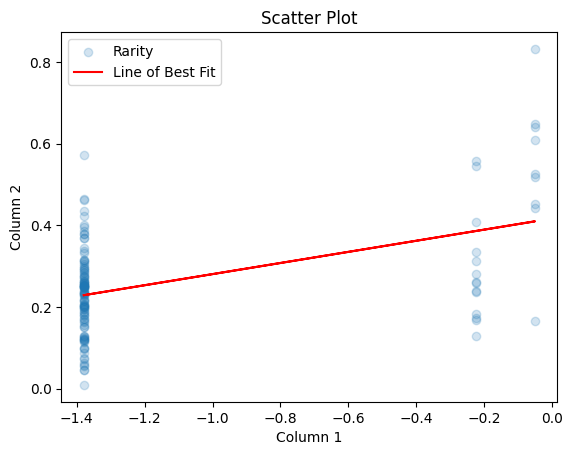

 74%|█████████████████████████████████████▉             | 78/105 [00:04<00:01, 22.56it/s]

(Rarity) Collection: bored-and-dangerous, Correlation: 0.4897955880488034, P-Value:2.897469696940523e-09


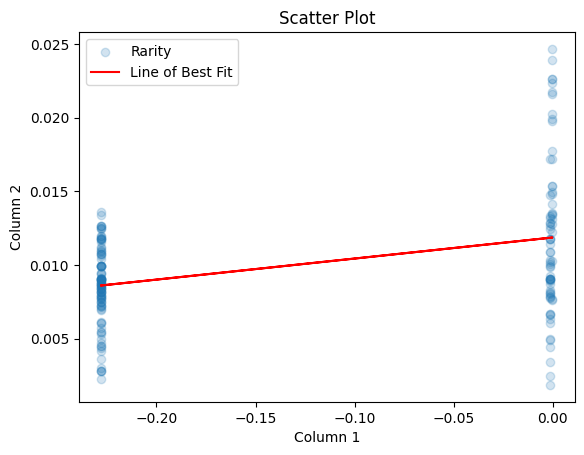

 77%|███████████████████████████████████████▎           | 81/105 [00:05<00:01, 21.74it/s]

(Rarity) Collection: bored-grapes-bottles, Correlation: 0.3789292916128625, P-Value:2.1490992122637394e-07


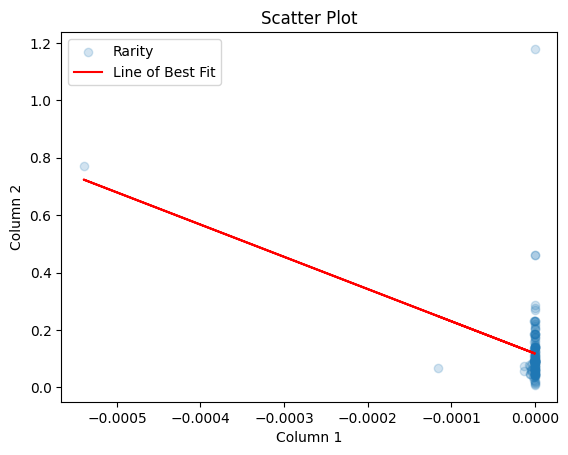

 80%|████████████████████████████████████████▊          | 84/105 [00:05<00:01, 20.67it/s]

(Rarity) Collection: bored-mummy-baby-waking-up, Correlation: -0.40850459624960217, P-Value:5.96743049667519e-07


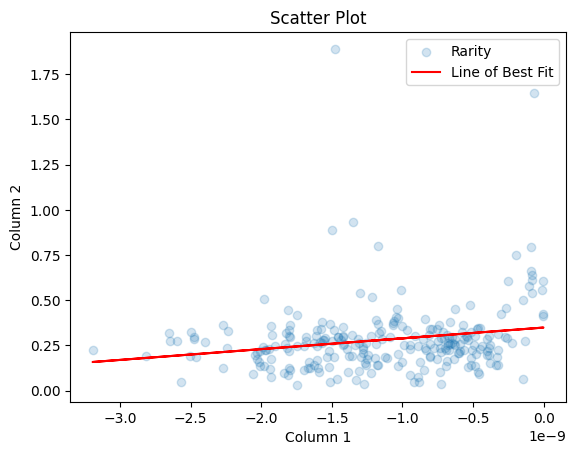

 90%|█████████████████████████████████████████████▋     | 94/105 [00:05<00:00, 31.37it/s]

(Rarity) Collection: cakedapesofficial, Correlation: 0.19989276420575905, P-Value:0.0013329257092294243


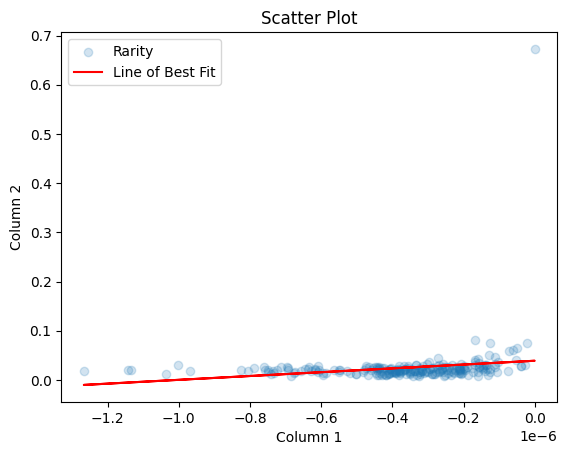

100%|██████████████████████████████████████████████████| 105/105 [00:05<00:00, 18.48it/s]

(Rarity) Collection: chaoscityresidents, Correlation: 0.187177445559883, P-Value:0.004569816472018739


In [10]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    x_1 = 1-group['rarity']
    y = group['sale_price']
    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x_1, y)
    if p_value<0.05:
        x_1 = np.log(x_1)
        plt.scatter(x_1,y,alpha=0.2,label='Rarity')
        plt.title('Scatter Plot')
        plt.xlabel('Column 1')
        # plt.xlim(left=0,right=1)
        plt.ylabel('Column 2')
        try:
            coefficients = np.polyfit(x_1, y, 1)
            line_of_best_fit = np.polyval(coefficients, x_1)
            # Plot the line of best fit
            plt.plot(x_1, line_of_best_fit, color='red', label='Line of Best Fit')
        except:
            continue
        plt.legend()
        plt.show()
        
        count+=1
        print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")